In [1]:
import os
cwd_old = os.getcwd()
dir_path = '../metadata/emo_pred'
os.chdir(dir_path)
cwd_new = os.getcwd()
print("The working directory is moved \nfrom {} \nto {}.".format(cwd_old, cwd_new))

The working directory is moved 
from /data2/sungjaecho/Projects/tacotron2/dev_ipynb 
to /data2/sungjaecho/Projects/tacotron2/metadata/emo_pred.


# 1. Defining prerequisites

In [2]:
import pandas as pd
import torch
from tqdm import tqdm
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
precision = 4

#emotions = ["sad", "happy", "fearful", "neutral", "disgusted", "angry", "surprised"]
convert_emo_str = {
    'happiness':'happy',
    'disgust':'disgusted',
    'fear':'fearful',
    'sadness':'sad',
    'surprise':'surprised',
    'angry':'angry',
    'neutral':'neutral'
}

def convert_file_name(file_name):
    return file_name.replace('_crop_logmel.npy','.wav')

def get_speaker_from_name(file_name):
    return file_name.split('_')[0]

def convert_emotion_string(emotion_string):
    return convert_emo_str[emotion_string]

def read_emo_pred_csv(csv_file):
    df = pd.read_csv(csv_file)
    df = df.rename(columns=convert_emo_str)
    
    df['file_name'] = df.file_name.apply(convert_file_name)
    df['speaker'] = df.file_name.apply(get_speaker_from_name)
    df['GT_label'] = df.GT_label.apply(convert_emotion_string)
    
    df = df[['file_name', 'speaker', 'GT_label'] + sorted(df.columns[1:-2].tolist())]
    
    df = df.sort_values(['file_name']).reset_index(drop=True)
    
    return df

def emotion_prediction(emotion_vector, emotion_labels, decision_threshold=0.5):
    if (emotion_vector > decision_threshold).sum() == 0.0:
        pred_emotion = 'neutral'
    else:
        pred_emotion = emotion_labels[emotion_vector.argmax()]
        
    return pred_emotion

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def filter_speaker(df, speaker):
    return df[df.speaker == speaker]
def get_speaker_indexes(df, speaker):
    return filter_speaker(df, speaker).index
def list_intersection(list1, list2):
    return sorted(list(set(list1).intersection(set(list2))))

In [4]:
def compute_stat(loss_step):
    
    ## 2.1. Import 3 seeds of the 1st loss
    
    df_list = list()

    seeds = [1,2,3]
    #steps = [1,2,3]
    step = loss_step

    for seed in seeds:
        csv_file = 'results_210226/seed_{}_step_{}/pred_list_1_loss_2.csv'.format(seed, step)
        df = read_emo_pred_csv(csv_file)
        df_list.append(df)

    emo_list = df_list[0].columns[3:].to_list()
    full_emo_list = emo_list + ['neutral']
    df_pred_list = list()
    emovec_list = list()
    for i, df in enumerate(df_list):
        df_pred_list.append(list())
        emovec_list.append(list())
        for j, row in tqdm(df.iterrows(),total=df.shape[0]):
            emovec = row[3:].to_numpy()
            emo_predition = emotion_prediction(emovec, emo_list)
            emovec_list[i].append(emovec)
            df_pred_list[i].append(emo_predition)

    ## 2.2. Compute emotion prediction consistency        
    
    for seed in seeds:
        GT_labels = df_list[0].GT_label.tolist()
        pred_emotions = df_pred_list[seed-1]
        np_cm = confusion_matrix(GT_labels, pred_emotions, labels=full_emo_list)
        plot_confusion_matrix(np_cm, full_emo_list, title='Confusion matrix (Seed {}, LossStep {})'.format(seed, step))

    speakers = df_list[0].speaker.unique().tolist()
    for speaker in speakers:
        for seed in seeds:
            speaker_indexes = get_speaker_indexes(df_list[0], speaker)
            GT_labels = np.array(df_list[0].GT_label.tolist())[speaker_indexes]
            pred_emotions = np.array(df_pred_list[seed-1])[speaker_indexes]
            np_cm = confusion_matrix(GT_labels, pred_emotions, labels=full_emo_list)
            plot_confusion_matrix(np_cm, full_emo_list, title='Confusion matrix (Seed {}, LossStep {}, speaker {})'.format(seed, step, speaker))

    mean_mae_list = list()
    for emovec1, emovec2, emovec3 in zip(emovec_list[0], emovec_list[1], emovec_list[2]):
        mean_mae = 0
        mean_mae += mean_absolute_error(emovec1, emovec2)
        mean_mae += mean_absolute_error(emovec2, emovec3)
        mean_mae += mean_absolute_error(emovec3, emovec1)
        mean_mae /= 3
        mean_mae_list.append(mean_mae)

    np_emo_pred_list = list()
    for df_pred in df_pred_list:
        np_emo_pred = np.asarray(df_pred)
        np_emo_pred_list.append(np_emo_pred)

    np_consistency = np.ones_like(np_emo_pred_list[0], dtype=np.int)
    for i in range(len(np_emo_pred_list)-1):
        np_emo_pred_1 = np_emo_pred_list[i]
        np_emo_pred_2 = np_emo_pred_list[i+1]
        np_consistency = np_consistency * (np_emo_pred_1 == np_emo_pred_2)

    print("[Check consistent decision among 3 runnings]")
    print("Consistency of 3 runnings", round(np_consistency.mean(), precision))
    consistent_indexes = np_consistency.nonzero()[0].squeeze()
    inconsistent_indexes = np.argwhere(np_consistency == 0).squeeze()
    np_consistent_classes = np_emo_pred_list[0][consistent_indexes]
    unique_classes, counts = np.unique(np_consistent_classes, return_counts=True)
    consistent_class_ratios = counts / counts.sum()
    print('[For consistent emotion samples]')
    for emotion, class_ratio in zip(unique_classes, consistent_class_ratios):
        print('└', emotion + '\t', '\t', round(class_ratio, precision))

    speakers = df_list[0].speaker.unique().tolist()
    for speaker in speakers:
        print('[For consistent emotion samples: speaker {}]'.format(speaker))
        speaker_indexes = get_speaker_indexes(df_list[0], speaker)
        print("Consistency of 3 runnings", round(np_consistency[speaker_indexes].mean(), precision))

        consistent_speaker_indexes = list_intersection(speaker_indexes, consistent_indexes)
        np_consistent_emotions = np_emo_pred_list[0][consistent_speaker_indexes]
        unique_emotions, counts = np.unique(np_consistent_emotions, return_counts=True)
        consistent_emotion_ratios = counts / counts.sum()
        for emotion, emotion_ratio in zip(unique_emotions, consistent_emotion_ratios):
            print('└', emotion + '\t', '\t', round(emotion_ratio, precision))

    ## 2.3. Compute emotion vector errors
    
    print('\n[Check MeanAbsoluteError(3RunningEmotionVectors)]')
    samples = mean_mae_list
    print("Mean\t\t", round(np.mean(samples), precision))
    print("Max\t\t", round(np.max(samples), precision))
    print("Min\t\t", round(np.min(samples), precision))
    print("STD\t\t", round(np.std(samples), precision))
    print("Skewness\t", round(stats.skew(samples), precision))
    plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
    plt.show()

    print('\n[Check MAE(3RunningEmotionVectors(consistent))]')
    samples = np.asarray(mean_mae_list)[consistent_indexes]
    print("Mean\t\t", round(np.mean(samples), precision))
    print("Max\t\t", round(np.max(samples), precision))
    print("Min\t\t", round(np.min(samples), precision))
    print("STD\t\t", round(np.std(samples), precision))
    print("Skewness\t", round(stats.skew(samples), precision))
    plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
    plt.show()

    print('\n[Check MAE(3RunningEmotionVectors(inconsistent))]')
    samples = np.asarray(mean_mae_list)[inconsistent_indexes]
    print("Mean\t\t", round(np.mean(samples), precision))
    print("Max\t\t", round(np.max(samples), precision))
    print("Min\t\t", round(np.min(samples), precision))
    print("STD\t\t", round(np.std(samples), precision))
    print("Skewness\t", round(stats.skew(samples), precision))
    plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
    plt.show()

    mean_mae_emo_dim_list = list()
    for i in consistent_indexes:
        emovec1 = emovec_list[0][i]
        emovec2 = emovec_list[1][i]
        emovec3 = emovec_list[2][i]
        emo_pred = np_emo_pred_list[0][i]
        if emo_pred == 'neutral':
            mean_mae = 0
            mean_mae += mean_absolute_error(emovec1, emovec2)
            mean_mae += mean_absolute_error(emovec2, emovec3)
            mean_mae += mean_absolute_error(emovec3, emovec1)
            mean_mae /= 3
        else:
            i_emo = emo_list.index(emo_pred)
            mean_mae = 0
            mean_mae += np.absolute(emovec1[i_emo] - emovec2[i_emo])
            mean_mae += np.absolute(emovec2[i_emo] - emovec3[i_emo])
            mean_mae += np.absolute(emovec3[i_emo] - emovec1[i_emo])
            mean_mae /= 3
        mean_mae_emo_dim_list.append(mean_mae)

    print('\n[Check MAE(3RunningEmotionVectorDim(consistent,predEmotions))]')
    samples = np.asarray(mean_mae_emo_dim_list)
    print("Mean\t\t", round(np.mean(samples), precision))
    print("Max\t\t", round(np.max(samples), precision))
    print("Min\t\t", round(np.min(samples), precision))
    print("STD\t\t", round(np.std(samples), precision))
    print("Skewness\t", round(stats.skew(samples), precision))
    plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
    plt.show()

    mean_mae_emo_dim_list = list()
    for i in consistent_indexes:
        emovec1 = emovec_list[0][i]
        emovec2 = emovec_list[1][i]
        emovec3 = emovec_list[2][i]
        emo_pred = df_list[0].GT_label[i]
        if emo_pred == 'neutral':
            mean_mae = 0
            mean_mae += mean_absolute_error(emovec1, emovec2)
            mean_mae += mean_absolute_error(emovec2, emovec3)
            mean_mae += mean_absolute_error(emovec3, emovec1)
            mean_mae /= 3
        else:
            i_emo = emo_list.index(emo_pred)
            mean_mae = 0
            mean_mae += np.absolute(emovec1[i_emo] - emovec2[i_emo])
            mean_mae += np.absolute(emovec2[i_emo] - emovec3[i_emo])
            mean_mae += np.absolute(emovec3[i_emo] - emovec1[i_emo])
            mean_mae /= 3
        mean_mae_emo_dim_list.append(mean_mae)

    print('\n[Check MAE(3RunningEmotionVectorDim(consistent,TrueEmotions))]')
    samples = np.asarray(mean_mae_emo_dim_list)
    print("Mean\t\t", round(np.mean(samples), precision))
    print("Max\t\t", round(np.max(samples), precision))
    print("Min\t\t", round(np.min(samples), precision))
    print("STD\t\t", round(np.std(samples), precision))
    print("Skewness\t", round(stats.skew(samples), precision))
    plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
    plt.show()

    mean_mae_emo_dim_list = list()
    for i in inconsistent_indexes:
        emovec1 = emovec_list[0][i]
        emovec2 = emovec_list[1][i]
        emovec3 = emovec_list[2][i]
        emo_pred = df_list[0].GT_label[i]
        if emo_pred == 'neutral':
            mean_mae = 0
            mean_mae += mean_absolute_error(emovec1, emovec2)
            mean_mae += mean_absolute_error(emovec2, emovec3)
            mean_mae += mean_absolute_error(emovec3, emovec1)
            mean_mae /= 3
        else:
            i_emo = emo_list.index(emo_pred)
            mean_mae = 0
            mean_mae += np.absolute(emovec1[i_emo] - emovec2[i_emo])
            mean_mae += np.absolute(emovec2[i_emo] - emovec3[i_emo])
            mean_mae += np.absolute(emovec3[i_emo] - emovec1[i_emo])
            mean_mae /= 3
        mean_mae_emo_dim_list.append(mean_mae)

    print('\n[Check MAE(3RunningEmotionVectorDim(inconsistent,TrueEmotions))]')
    samples = np.asarray(mean_mae_emo_dim_list)
    print("Mean\t\t", round(np.mean(samples), precision))
    print("Max\t\t", round(np.max(samples), precision))
    print("Min\t\t", round(np.min(samples), precision))
    print("STD\t\t", round(np.std(samples), precision))
    print("Skewness\t", round(stats.skew(samples), precision))
    plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
    plt.show()

    mean_mae_emo_dim_list = list()
    for i in range(len(emovec_list[0])):
        emovec1 = emovec_list[0][i]
        emovec2 = emovec_list[1][i]
        emovec3 = emovec_list[2][i]
        emo_pred = df_list[0].GT_label[i]
        if emo_pred == 'neutral':
            mean_mae = 0
            mean_mae += mean_absolute_error(emovec1, emovec2)
            mean_mae += mean_absolute_error(emovec2, emovec3)
            mean_mae += mean_absolute_error(emovec3, emovec1)
            mean_mae /= 3
        else:
            i_emo = emo_list.index(emo_pred)
            mean_mae = 0
            mean_mae += np.absolute(emovec1[i_emo] - emovec2[i_emo])
            mean_mae += np.absolute(emovec2[i_emo] - emovec3[i_emo])
            mean_mae += np.absolute(emovec3[i_emo] - emovec1[i_emo])
            mean_mae /= 3
        mean_mae_emo_dim_list.append(mean_mae)

    print('\n[Check MAE(3RunningEmotionVectorDim(total,TrueEmotions))]')
    samples = np.asarray(mean_mae_emo_dim_list)
    print("Mean\t\t", round(np.mean(samples), precision))
    print("Max\t\t", round(np.max(samples), precision))
    print("Min\t\t", round(np.min(samples), precision))
    print("STD\t\t", round(np.std(samples), precision))
    print("Skewness\t", round(stats.skew(samples), precision))
    plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
    plt.show()

# 2. Comptue statistics

## 2.1. Import 3 seeds of the 1st loss

In [5]:
df_list = list()

seeds = [1,2,3]
#steps = [1,2,3]
step = 1

for seed in seeds:
    csv_file = 'results_210226/seed_{}_step_{}/pred_list_1_loss_2.csv'.format(seed, step)
    df = read_emo_pred_csv(csv_file)
    df_list.append(df)

emo_list = df_list[0].columns[3:].to_list()
full_emo_list = emo_list + ['neutral']
df_pred_list = list()
emovec_list = list()
for i, df in enumerate(df_list):
    df_pred_list.append(list())
    emovec_list.append(list())
    for j, row in tqdm(df.iterrows(),total=df.shape[0]):
        emovec = row[3:].to_numpy()
        emo_predition = emotion_prediction(emovec, emo_list)
        emovec_list[i].append(emovec)
        df_pred_list[i].append(emo_predition)
        

100%|██████████| 79168/79168 [00:12<00:00, 6376.01it/s]


## 2.2. Compute emotion prediction consistency

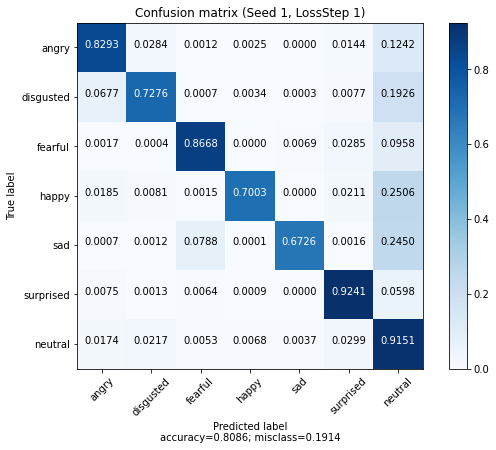

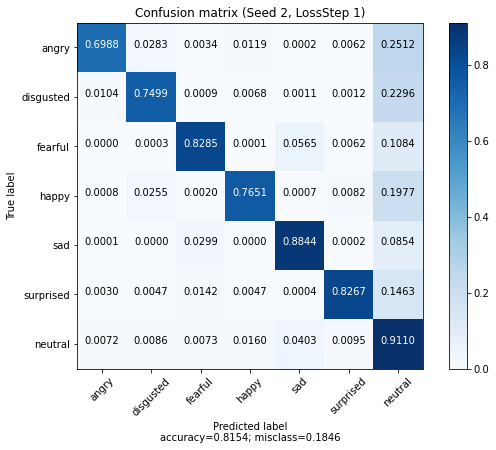

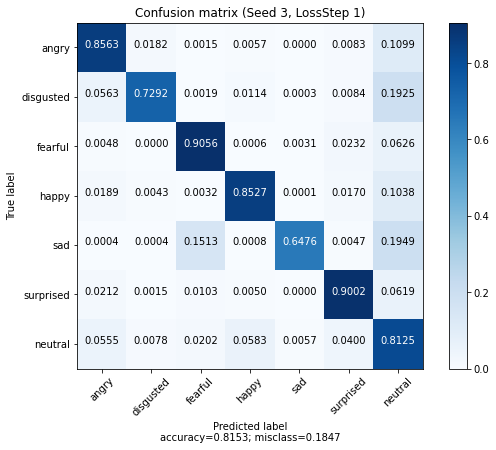

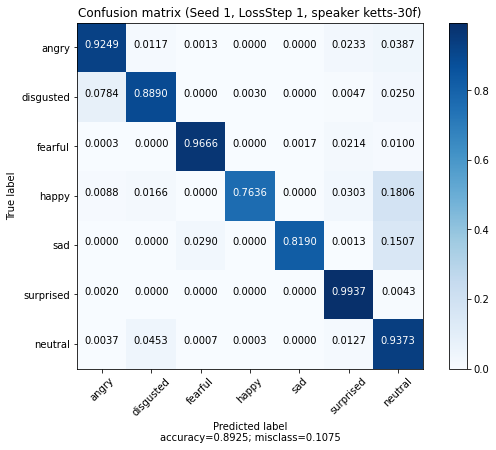

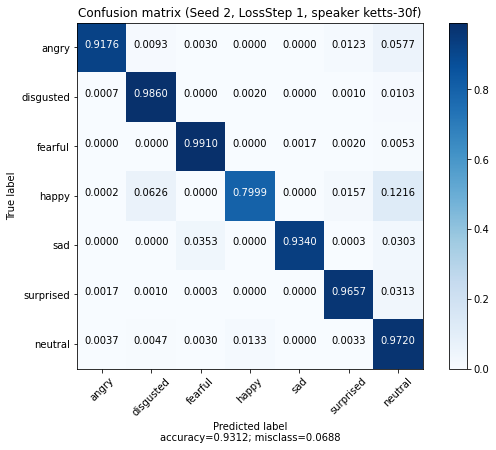

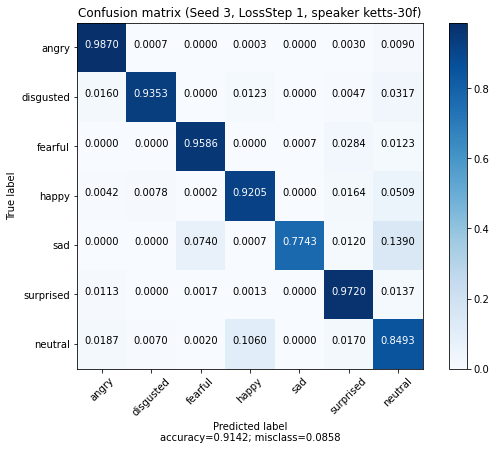

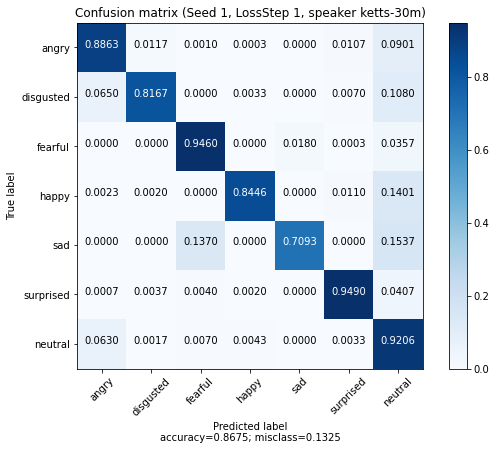

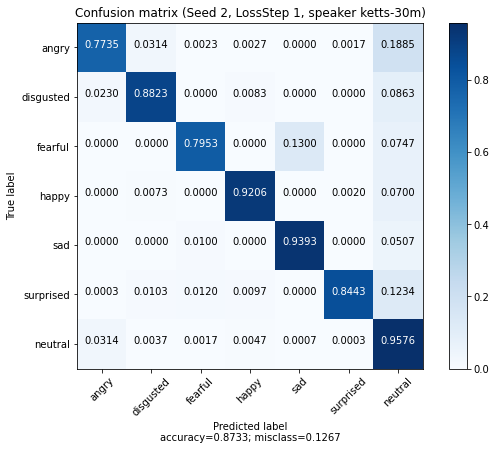

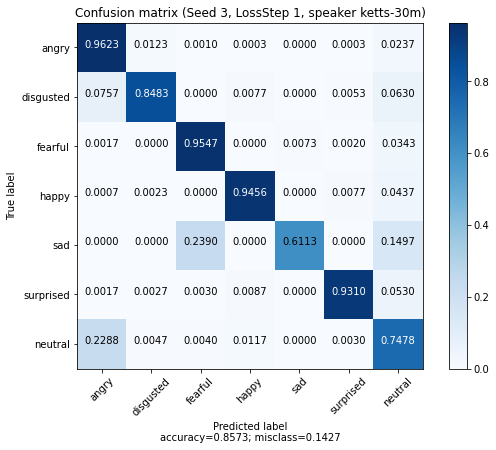

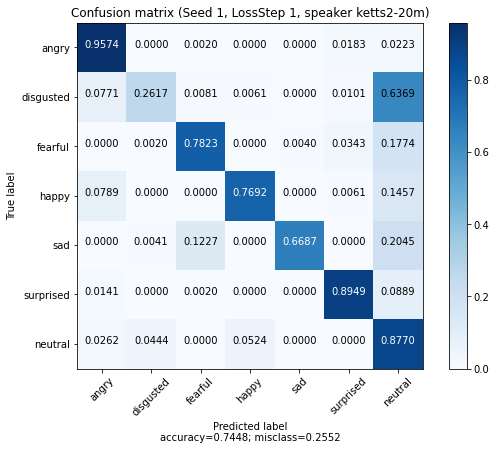

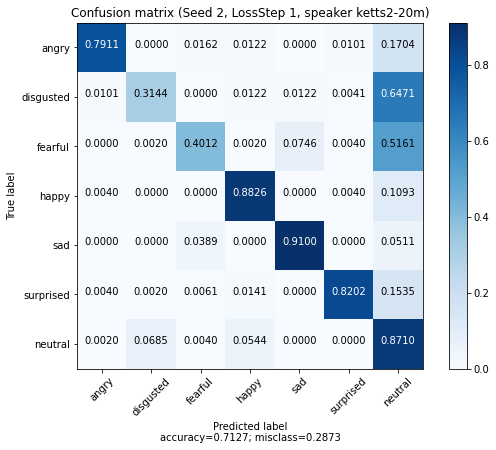

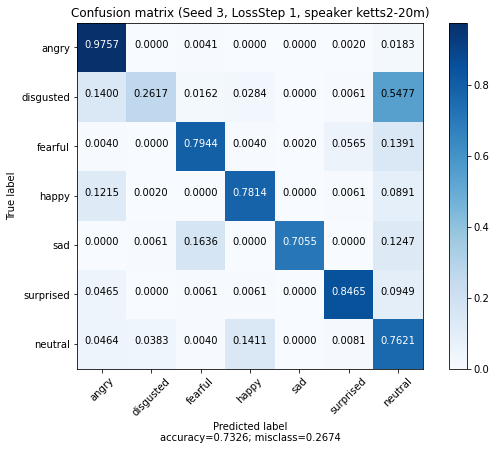

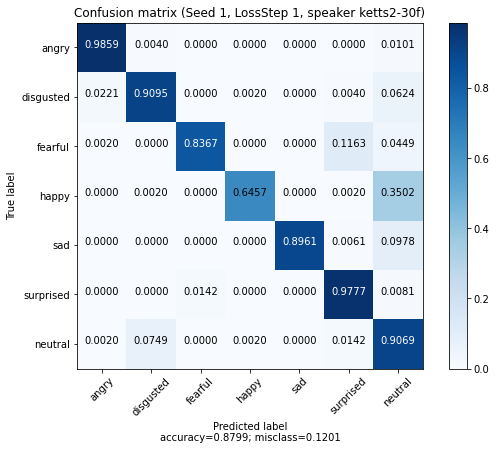

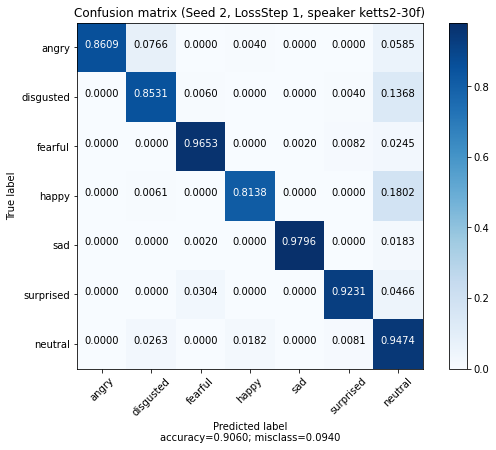

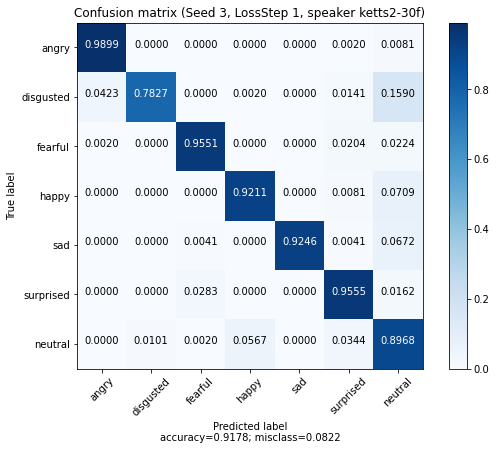

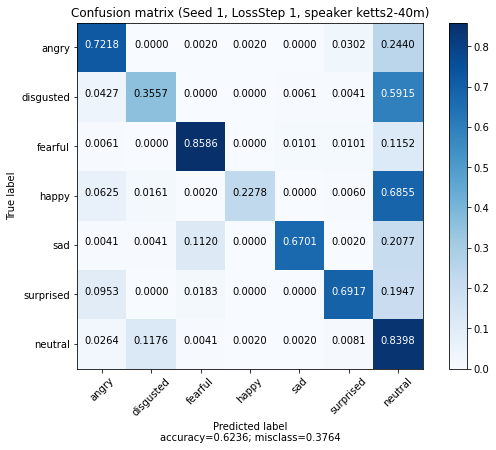

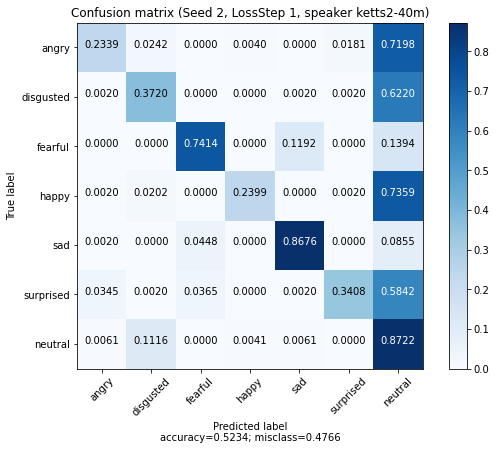

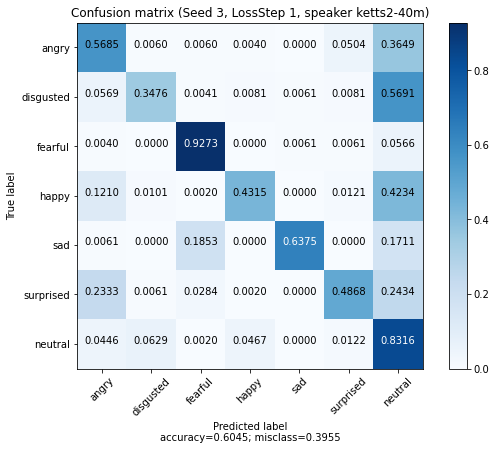

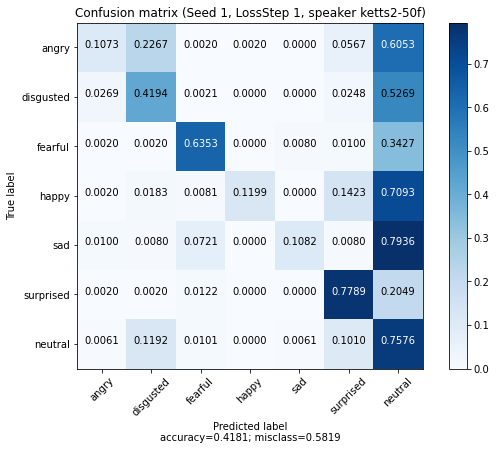

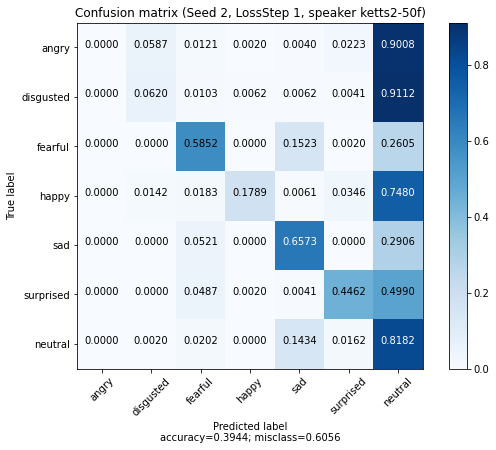

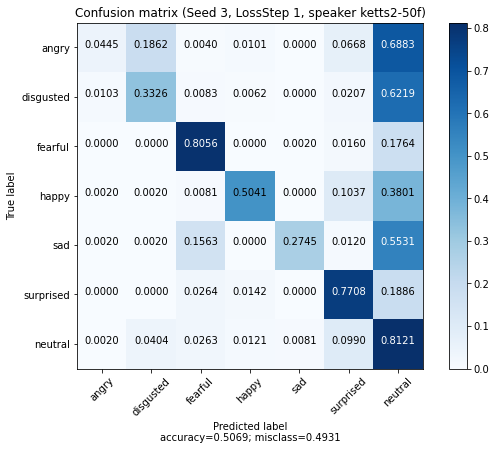

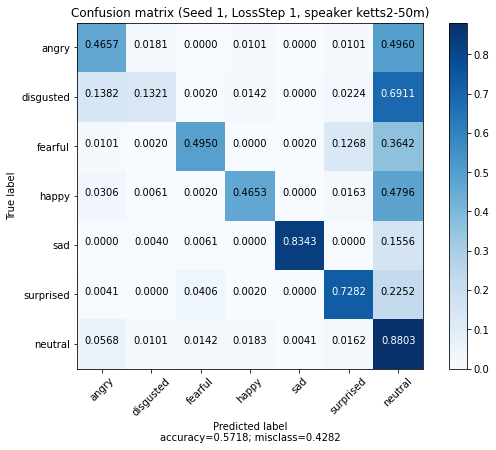

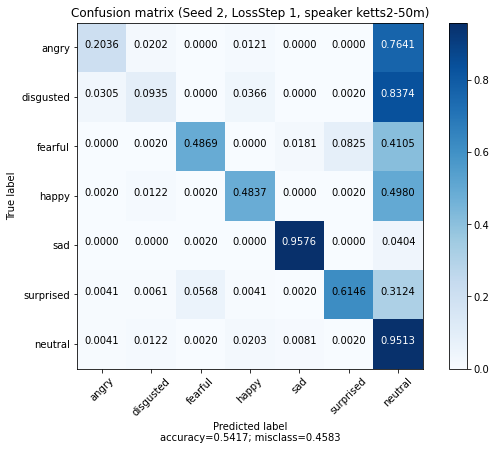

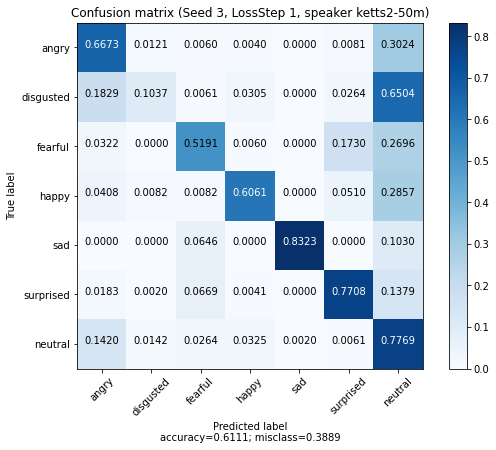

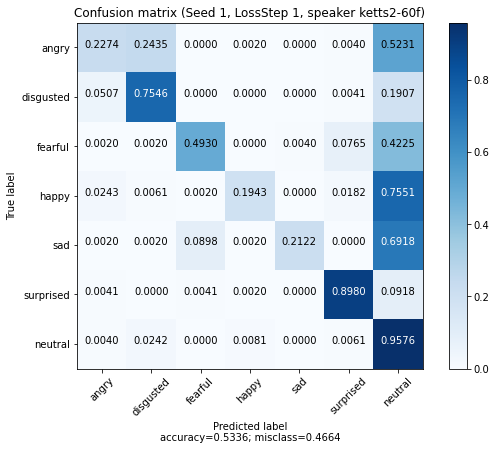

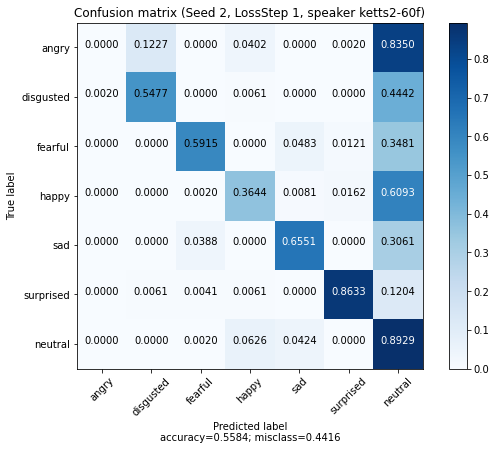

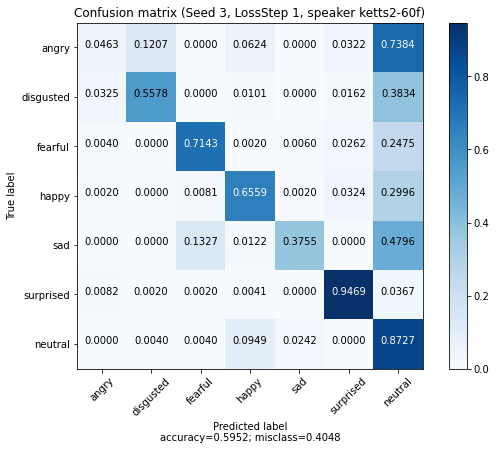

/data2/sungjaecho/anaconda3/envs/taco2/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


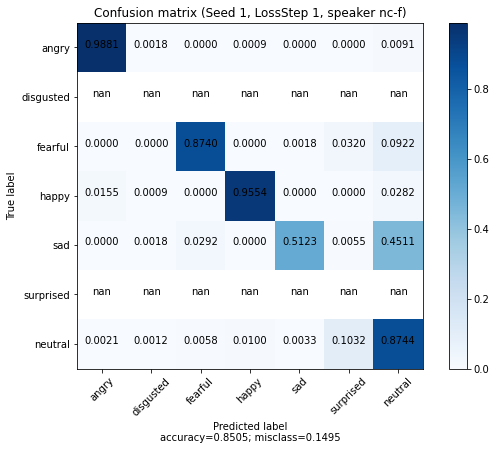

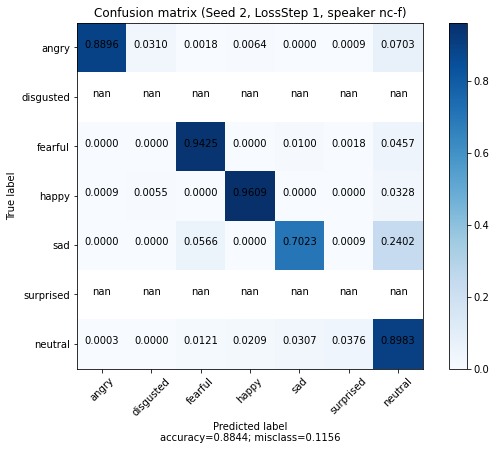

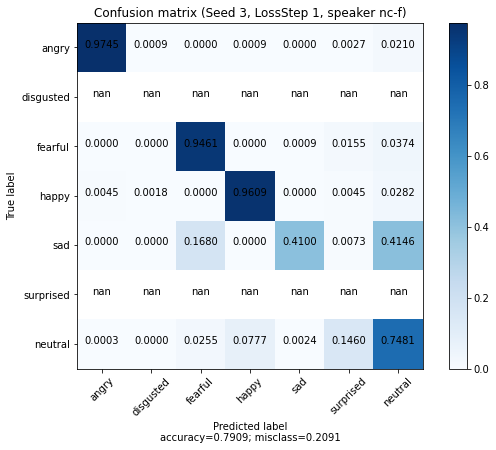

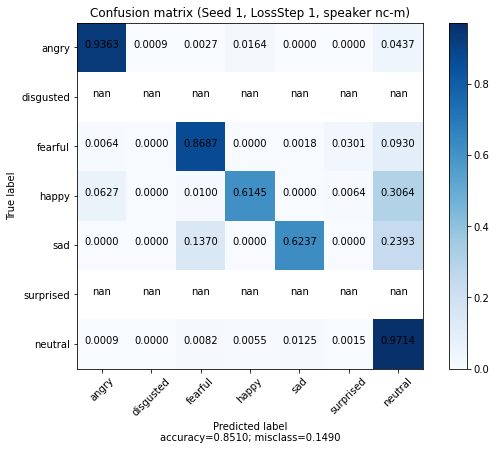

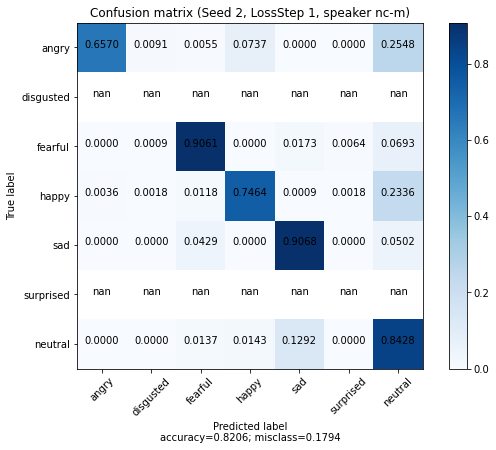

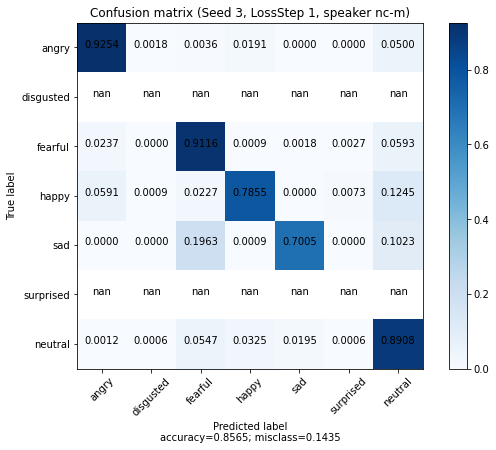

[Check consistent decision among 3 runnings]
Consistency of 3 runnings 0.7293
[For consistent emotion samples]
└ angry	 	 0.132
└ disgusted	 	 0.0964
└ fearful	 	 0.1497
└ happy	 	 0.1362
└ neutral	 	 0.2532
└ sad	 	 0.1069
└ surprised	 	 0.1256
[For consistent emotion samples: speaker ketts-30f]
Consistency of 3 runnings 0.833
└ angry	 	 0.1432
└ disgusted	 	 0.1395
└ fearful	 	 0.1539
└ happy	 	 0.1554
└ neutral	 	 0.136
└ sad	 	 0.1154
└ surprised	 	 0.1567
[For consistent emotion samples: speaker ketts-30m]
Consistency of 3 runnings 0.7505
└ angry	 	 0.1441
└ disgusted	 	 0.1407
└ fearful	 	 0.1498
└ happy	 	 0.1554
└ neutral	 	 0.1519
└ sad	 	 0.1031
└ surprised	 	 0.155
[For consistent emotion samples: speaker ketts2-20m]
Consistency of 3 runnings 0.6363
└ angry	 	 0.1778
└ disgusted	 	 0.0291
└ fearful	 	 0.0864
└ happy	 	 0.1542
└ neutral	 	 0.2528
└ sad	 	 0.1301
└ surprised	 	 0.1696
[For consistent emotion samples: speaker ketts2-30f]
Consistency of 3 runnings 0.8067
└ angry

In [6]:
for seed in seeds:
    GT_labels = df_list[0].GT_label.tolist()
    pred_emotions = df_pred_list[seed-1]
    np_cm = confusion_matrix(GT_labels, pred_emotions, labels=full_emo_list)
    plot_confusion_matrix(np_cm, full_emo_list, title='Confusion matrix (Seed {}, LossStep {})'.format(seed, step))

speakers = df_list[0].speaker.unique().tolist()
for speaker in speakers:
    for seed in seeds:
        speaker_indexes = get_speaker_indexes(df_list[0], speaker)
        GT_labels = np.array(df_list[0].GT_label.tolist())[speaker_indexes]
        pred_emotions = np.array(df_pred_list[seed-1])[speaker_indexes]
        np_cm = confusion_matrix(GT_labels, pred_emotions, labels=full_emo_list)
        plot_confusion_matrix(np_cm, full_emo_list, title='Confusion matrix (Seed {}, LossStep {}, speaker {})'.format(seed, step, speaker))

mean_mae_list = list()
for emovec1, emovec2, emovec3 in zip(emovec_list[0], emovec_list[1], emovec_list[2]):
    mean_mae = 0
    mean_mae += mean_absolute_error(emovec1, emovec2)
    mean_mae += mean_absolute_error(emovec2, emovec3)
    mean_mae += mean_absolute_error(emovec3, emovec1)
    mean_mae /= 3
    mean_mae_list.append(mean_mae)

np_emo_pred_list = list()
for df_pred in df_pred_list:
    np_emo_pred = np.asarray(df_pred)
    np_emo_pred_list.append(np_emo_pred)
    
np_consistency = np.ones_like(np_emo_pred_list[0], dtype=np.int)
for i in range(len(np_emo_pred_list)-1):
    np_emo_pred_1 = np_emo_pred_list[i]
    np_emo_pred_2 = np_emo_pred_list[i+1]
    np_consistency = np_consistency * (np_emo_pred_1 == np_emo_pred_2)
    
print("[Check consistent decision among 3 runnings]")
print("Consistency of 3 runnings", round(np_consistency.mean(), precision))
consistent_indexes = np_consistency.nonzero()[0].squeeze()
inconsistent_indexes = np.argwhere(np_consistency == 0).squeeze()
np_consistent_classes = np_emo_pred_list[0][consistent_indexes]
unique_classes, counts = np.unique(np_consistent_classes, return_counts=True)
consistent_class_ratios = counts / counts.sum()
print('[For consistent emotion samples]')
for emotion, class_ratio in zip(unique_classes, consistent_class_ratios):
    print('└', emotion + '\t', '\t', round(class_ratio, precision))
    
speakers = df_list[0].speaker.unique().tolist()
for speaker in speakers:
    print('[For consistent emotion samples: speaker {}]'.format(speaker))
    speaker_indexes = get_speaker_indexes(df_list[0], speaker)
    print("Consistency of 3 runnings", round(np_consistency[speaker_indexes].mean(), precision))

    consistent_speaker_indexes = list_intersection(speaker_indexes, consistent_indexes)
    np_consistent_emotions = np_emo_pred_list[0][consistent_speaker_indexes]
    unique_emotions, counts = np.unique(np_consistent_emotions, return_counts=True)
    consistent_emotion_ratios = counts / counts.sum()
    for emotion, emotion_ratio in zip(unique_emotions, consistent_emotion_ratios):
        print('└', emotion + '\t', '\t', round(emotion_ratio, precision))

## 2.3. Compute emotion vector errors


[Check MeanAbsoluteError(3RunningEmotionVectors)]
Mean		 0.049
Max		 0.3244
Min		 0.0
STD		 0.0513
Skewness	 0.9903


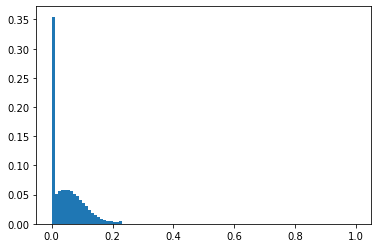


[Check MAE(3RunningEmotionVectors(consistent))]
Mean		 0.0262
Max		 0.1908
Min		 0.0
STD		 0.032
Skewness	 1.1743


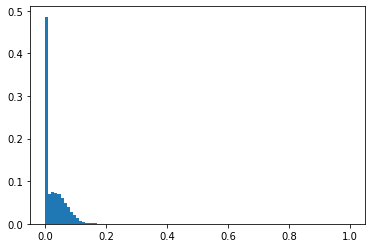


[Check MAE(3RunningEmotionVectors(inconsistent))]
Mean		 0.1103
Max		 0.3244
Min		 0.007
STD		 0.0425
Skewness	 0.6219


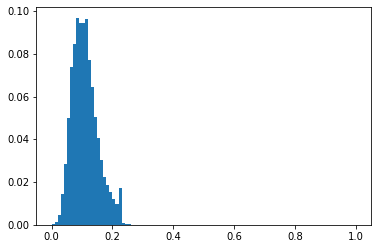


[Check MAE(3RunningEmotionVectorDim(consistent,predEmotions))]
Mean		 0.0593
Max		 0.3333
Min		 0.0
STD		 0.0825
Skewness	 1.5101


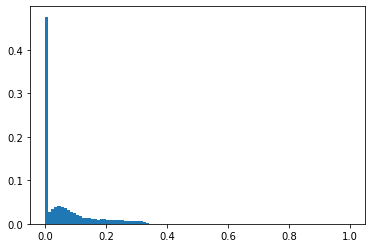


[Check MAE(3RunningEmotionVectorDim(consistent,TrueEmotions))]
Mean		 0.0616
Max		 0.5782
Min		 0.0
STD		 0.085
Skewness	 1.4253


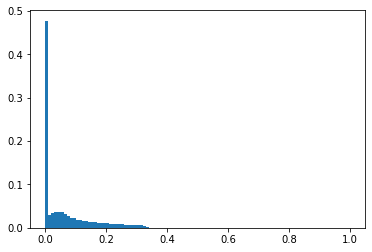


[Check MAE(3RunningEmotionVectorDim(inconsistent,TrueEmotions))]
Mean		 0.3034
Max		 0.6667
Min		 0.0
STD		 0.1725
Skewness	 0.2248


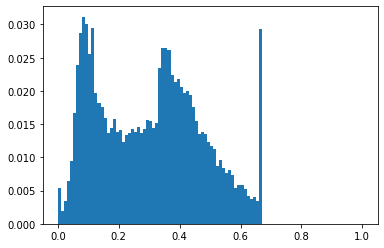


[Check MAE(3RunningEmotionVectorDim(total,TrueEmotions))]
Mean		 0.1271
Max		 0.6667
Min		 0.0
STD		 0.1577
Skewness	 1.3918


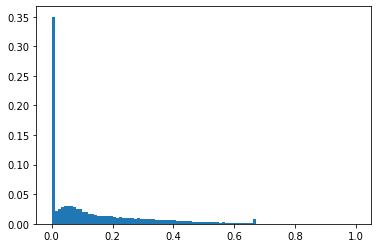

In [7]:
print('\n[Check MeanAbsoluteError(3RunningEmotionVectors)]')
samples = mean_mae_list
print("Mean\t\t", round(np.mean(samples), precision))
print("Max\t\t", round(np.max(samples), precision))
print("Min\t\t", round(np.min(samples), precision))
print("STD\t\t", round(np.std(samples), precision))
print("Skewness\t", round(stats.skew(samples), precision))
plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
plt.show()

print('\n[Check MAE(3RunningEmotionVectors(consistent))]')
samples = np.asarray(mean_mae_list)[consistent_indexes]
print("Mean\t\t", round(np.mean(samples), precision))
print("Max\t\t", round(np.max(samples), precision))
print("Min\t\t", round(np.min(samples), precision))
print("STD\t\t", round(np.std(samples), precision))
print("Skewness\t", round(stats.skew(samples), precision))
plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
plt.show()

print('\n[Check MAE(3RunningEmotionVectors(inconsistent))]')
samples = np.asarray(mean_mae_list)[inconsistent_indexes]
print("Mean\t\t", round(np.mean(samples), precision))
print("Max\t\t", round(np.max(samples), precision))
print("Min\t\t", round(np.min(samples), precision))
print("STD\t\t", round(np.std(samples), precision))
print("Skewness\t", round(stats.skew(samples), precision))
plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
plt.show()

mean_mae_emo_dim_list = list()
for i in consistent_indexes:
    emovec1 = emovec_list[0][i]
    emovec2 = emovec_list[1][i]
    emovec3 = emovec_list[2][i]
    emo_pred = np_emo_pred_list[0][i]
    if emo_pred == 'neutral':
        mean_mae = 0
        mean_mae += mean_absolute_error(emovec1, emovec2)
        mean_mae += mean_absolute_error(emovec2, emovec3)
        mean_mae += mean_absolute_error(emovec3, emovec1)
        mean_mae /= 3
    else:
        i_emo = emo_list.index(emo_pred)
        mean_mae = 0
        mean_mae += np.absolute(emovec1[i_emo] - emovec2[i_emo])
        mean_mae += np.absolute(emovec2[i_emo] - emovec3[i_emo])
        mean_mae += np.absolute(emovec3[i_emo] - emovec1[i_emo])
        mean_mae /= 3
    mean_mae_emo_dim_list.append(mean_mae)

print('\n[Check MAE(3RunningEmotionVectorDim(consistent,predEmotions))]')
samples = np.asarray(mean_mae_emo_dim_list)
print("Mean\t\t", round(np.mean(samples), precision))
print("Max\t\t", round(np.max(samples), precision))
print("Min\t\t", round(np.min(samples), precision))
print("STD\t\t", round(np.std(samples), precision))
print("Skewness\t", round(stats.skew(samples), precision))
plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
plt.show()

mean_mae_emo_dim_list = list()
for i in consistent_indexes:
    emovec1 = emovec_list[0][i]
    emovec2 = emovec_list[1][i]
    emovec3 = emovec_list[2][i]
    emo_pred = df_list[0].GT_label[i]
    if emo_pred == 'neutral':
        mean_mae = 0
        mean_mae += mean_absolute_error(emovec1, emovec2)
        mean_mae += mean_absolute_error(emovec2, emovec3)
        mean_mae += mean_absolute_error(emovec3, emovec1)
        mean_mae /= 3
    else:
        i_emo = emo_list.index(emo_pred)
        mean_mae = 0
        mean_mae += np.absolute(emovec1[i_emo] - emovec2[i_emo])
        mean_mae += np.absolute(emovec2[i_emo] - emovec3[i_emo])
        mean_mae += np.absolute(emovec3[i_emo] - emovec1[i_emo])
        mean_mae /= 3
    mean_mae_emo_dim_list.append(mean_mae)

print('\n[Check MAE(3RunningEmotionVectorDim(consistent,TrueEmotions))]')
samples = np.asarray(mean_mae_emo_dim_list)
print("Mean\t\t", round(np.mean(samples), precision))
print("Max\t\t", round(np.max(samples), precision))
print("Min\t\t", round(np.min(samples), precision))
print("STD\t\t", round(np.std(samples), precision))
print("Skewness\t", round(stats.skew(samples), precision))
plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
plt.show()

mean_mae_emo_dim_list = list()
for i in inconsistent_indexes:
    emovec1 = emovec_list[0][i]
    emovec2 = emovec_list[1][i]
    emovec3 = emovec_list[2][i]
    emo_pred = df_list[0].GT_label[i]
    if emo_pred == 'neutral':
        mean_mae = 0
        mean_mae += mean_absolute_error(emovec1, emovec2)
        mean_mae += mean_absolute_error(emovec2, emovec3)
        mean_mae += mean_absolute_error(emovec3, emovec1)
        mean_mae /= 3
    else:
        i_emo = emo_list.index(emo_pred)
        mean_mae = 0
        mean_mae += np.absolute(emovec1[i_emo] - emovec2[i_emo])
        mean_mae += np.absolute(emovec2[i_emo] - emovec3[i_emo])
        mean_mae += np.absolute(emovec3[i_emo] - emovec1[i_emo])
        mean_mae /= 3
    mean_mae_emo_dim_list.append(mean_mae)

print('\n[Check MAE(3RunningEmotionVectorDim(inconsistent,TrueEmotions))]')
samples = np.asarray(mean_mae_emo_dim_list)
print("Mean\t\t", round(np.mean(samples), precision))
print("Max\t\t", round(np.max(samples), precision))
print("Min\t\t", round(np.min(samples), precision))
print("STD\t\t", round(np.std(samples), precision))
print("Skewness\t", round(stats.skew(samples), precision))
plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
plt.show()

mean_mae_emo_dim_list = list()
for i in range(len(emovec_list[0])):
    emovec1 = emovec_list[0][i]
    emovec2 = emovec_list[1][i]
    emovec3 = emovec_list[2][i]
    emo_pred = df_list[0].GT_label[i]
    if emo_pred == 'neutral':
        mean_mae = 0
        mean_mae += mean_absolute_error(emovec1, emovec2)
        mean_mae += mean_absolute_error(emovec2, emovec3)
        mean_mae += mean_absolute_error(emovec3, emovec1)
        mean_mae /= 3
    else:
        i_emo = emo_list.index(emo_pred)
        mean_mae = 0
        mean_mae += np.absolute(emovec1[i_emo] - emovec2[i_emo])
        mean_mae += np.absolute(emovec2[i_emo] - emovec3[i_emo])
        mean_mae += np.absolute(emovec3[i_emo] - emovec1[i_emo])
        mean_mae /= 3
    mean_mae_emo_dim_list.append(mean_mae)

print('\n[Check MAE(3RunningEmotionVectorDim(total,TrueEmotions))]')
samples = np.asarray(mean_mae_emo_dim_list)
print("Mean\t\t", round(np.mean(samples), precision))
print("Max\t\t", round(np.max(samples), precision))
print("Min\t\t", round(np.min(samples), precision))
print("STD\t\t", round(np.std(samples), precision))
print("Skewness\t", round(stats.skew(samples), precision))
plt.hist(samples, range=(0,1), bins=100, weights=np.ones_like(samples)/float(len(samples)))
plt.show()

## 2.2. Import 3 seeds of the 2nd loss

100%|██████████| 79168/79168 [00:12<00:00, 6354.92it/s]


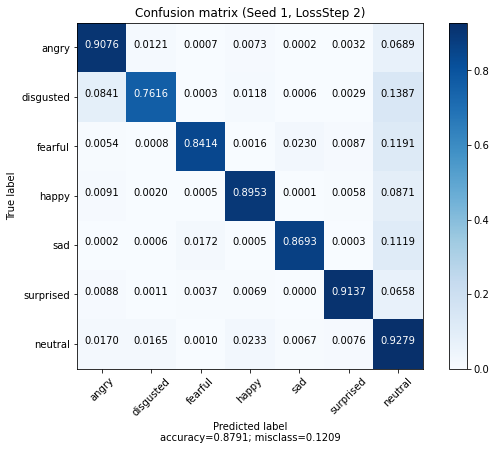

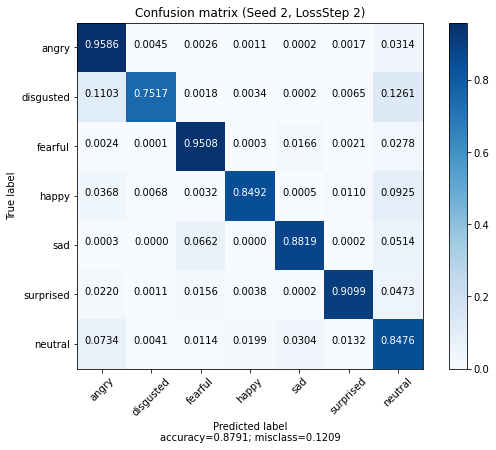

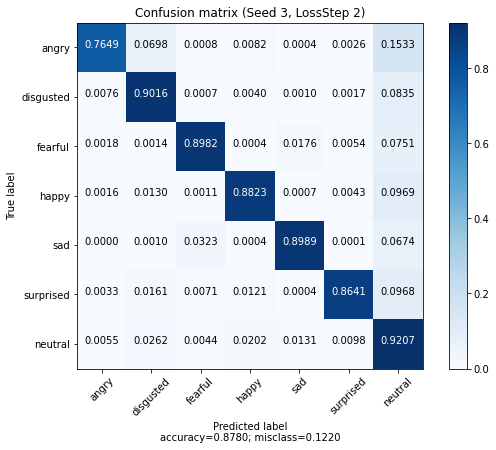

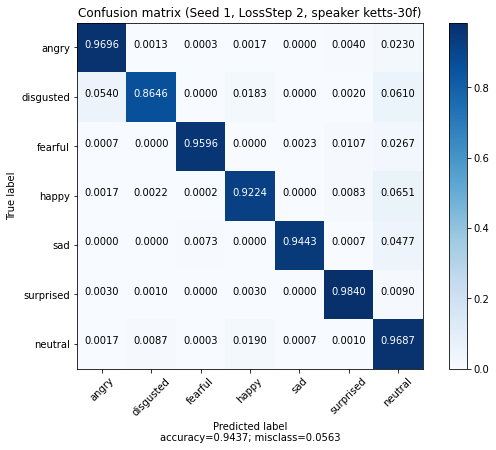

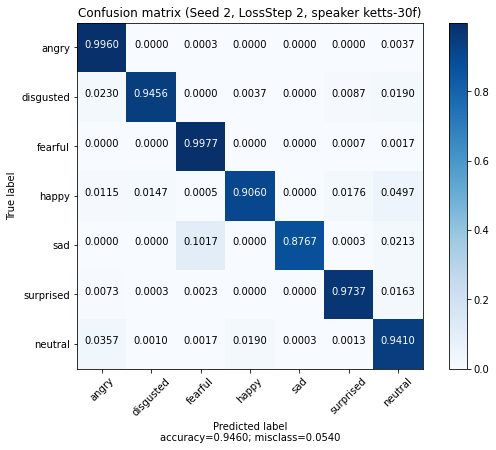

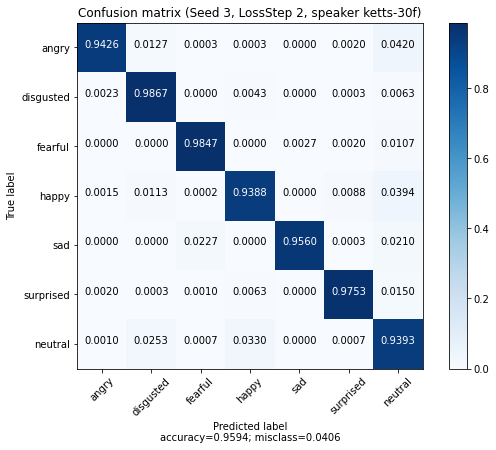

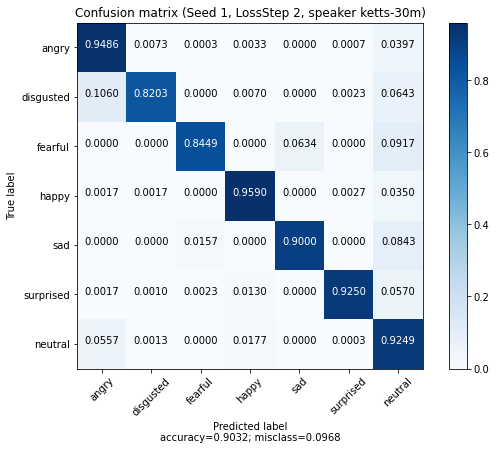

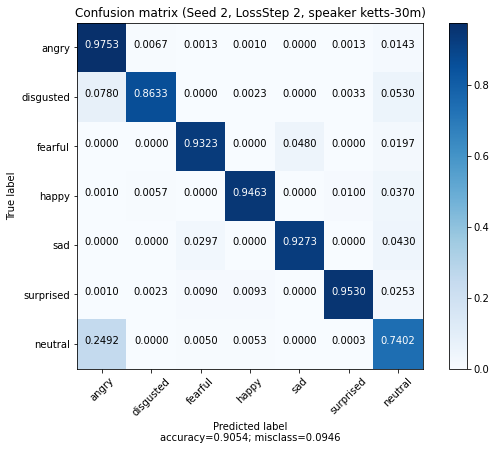

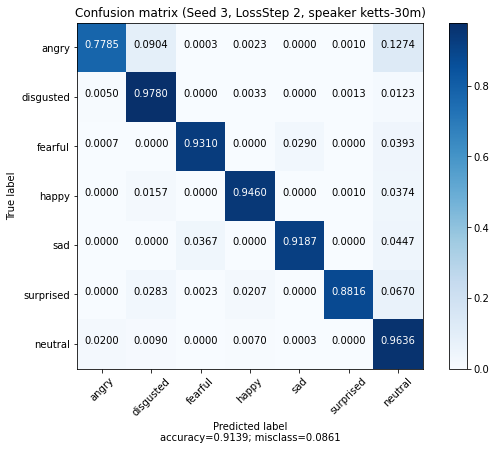

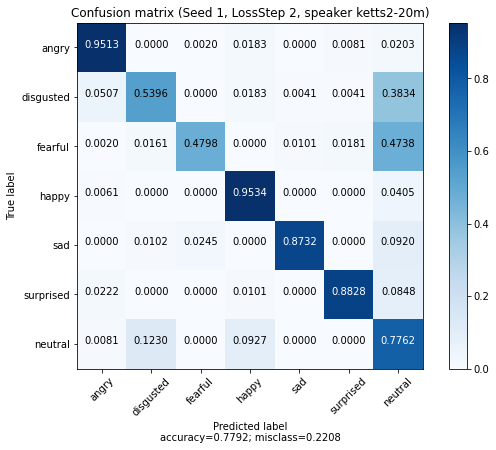

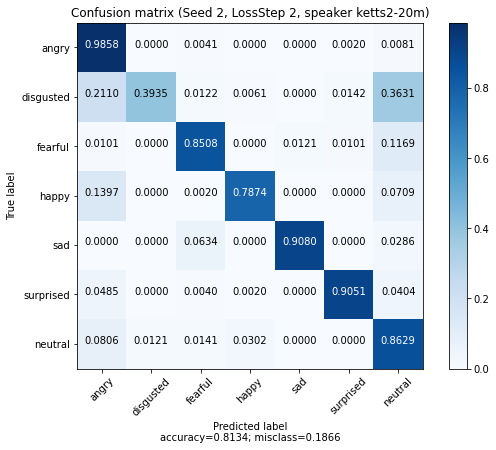

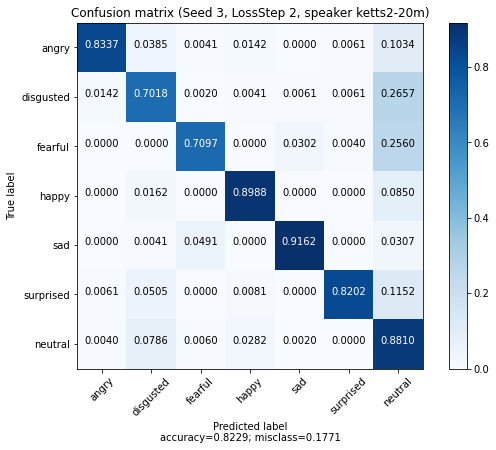

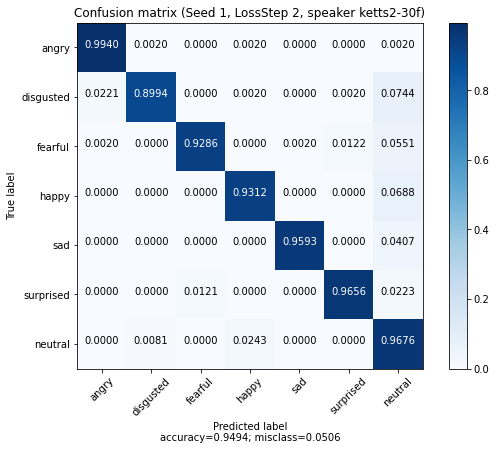

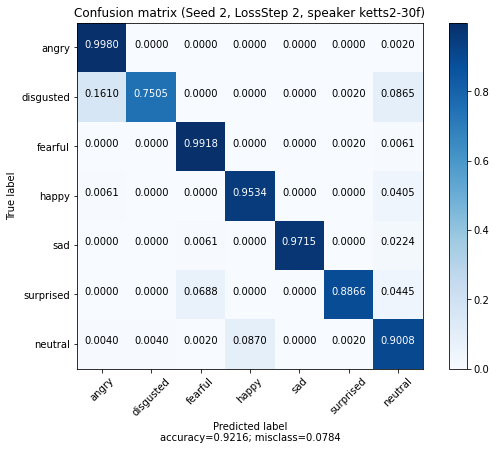

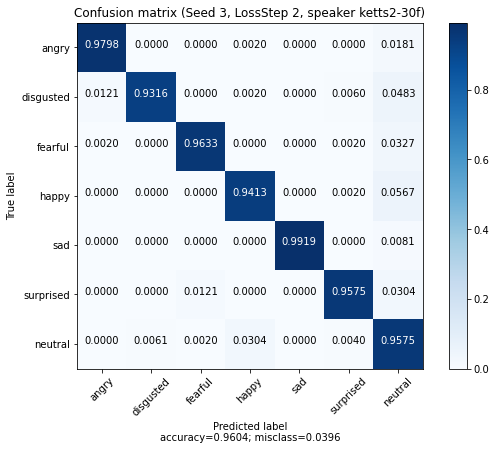

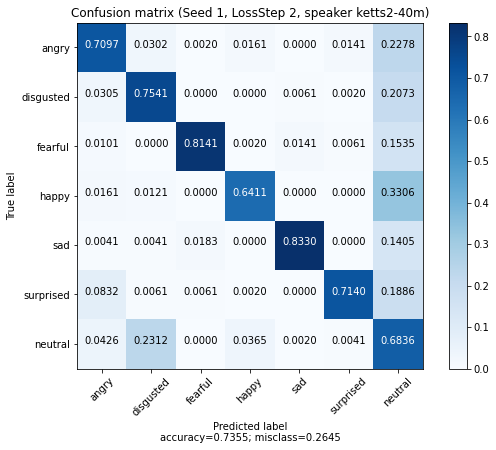

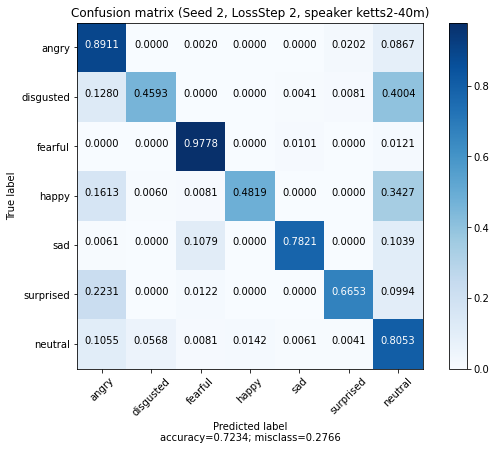

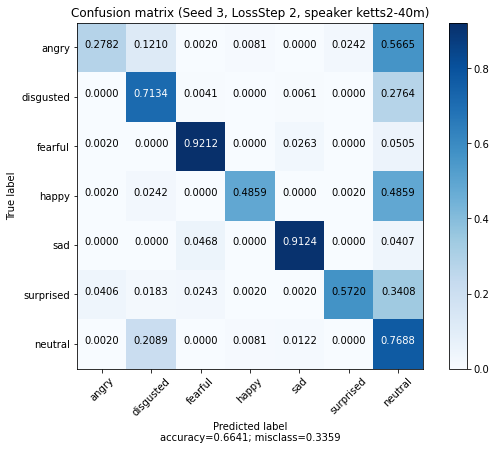

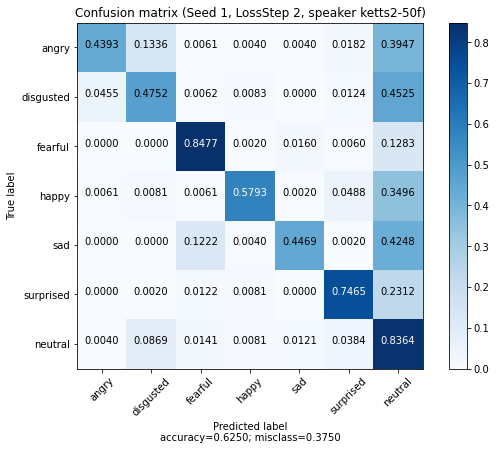

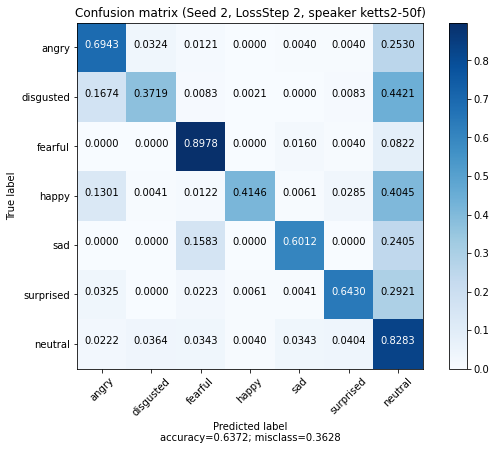

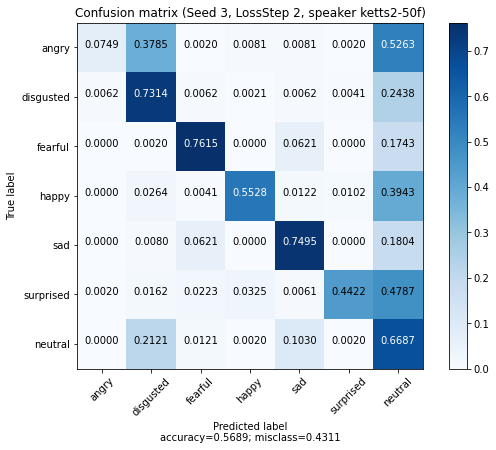

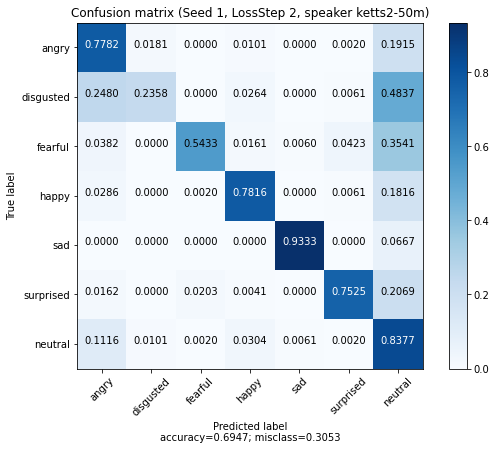

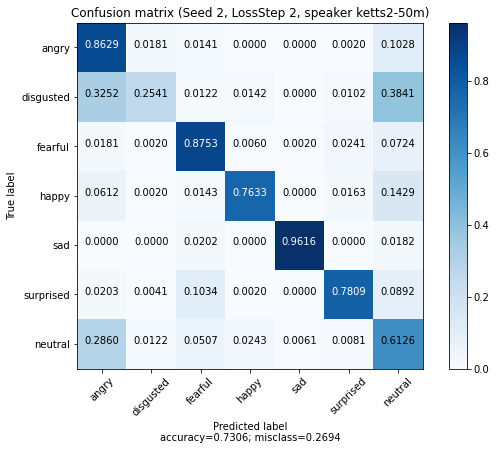

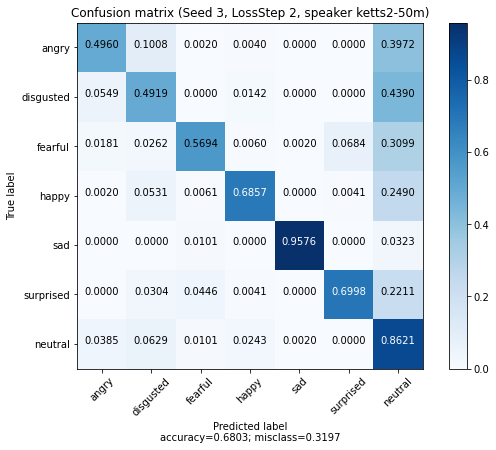

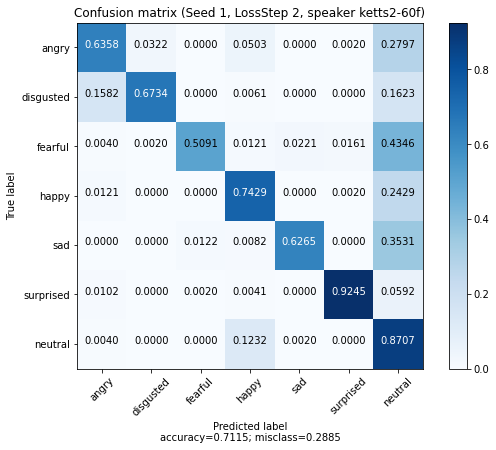

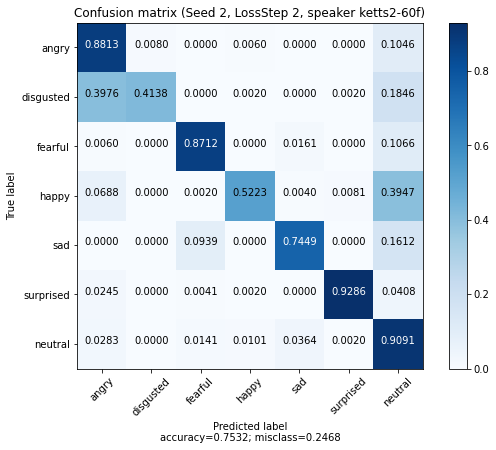

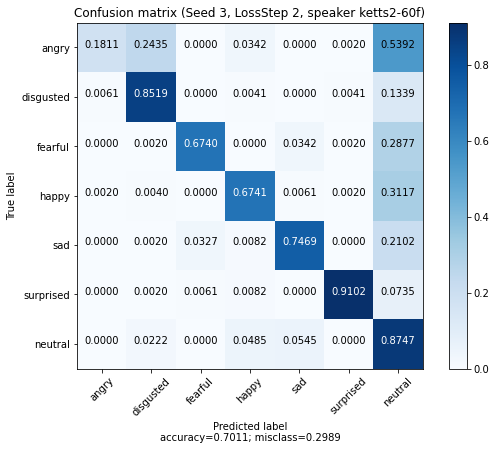

/data2/sungjaecho/anaconda3/envs/taco2/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


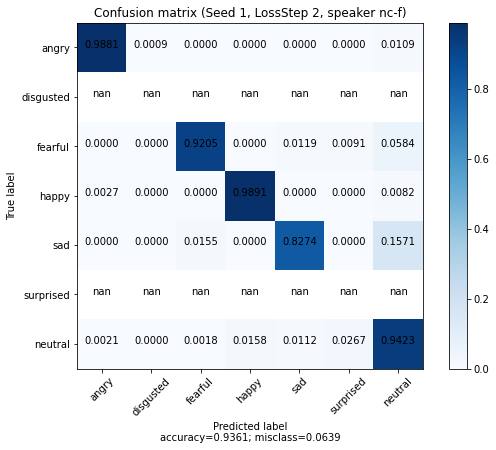

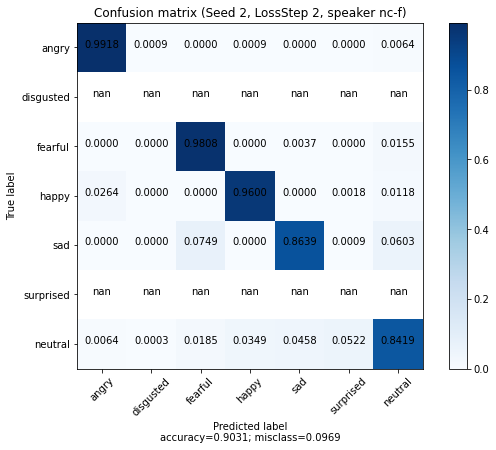

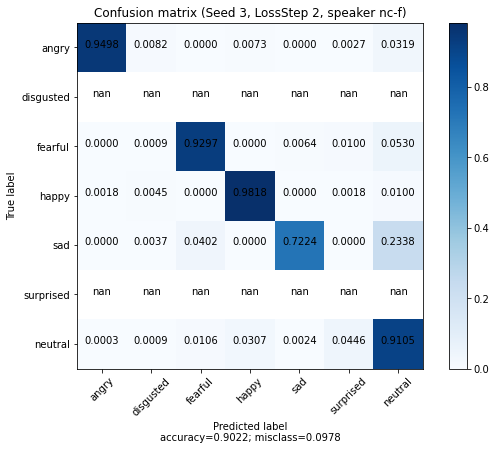

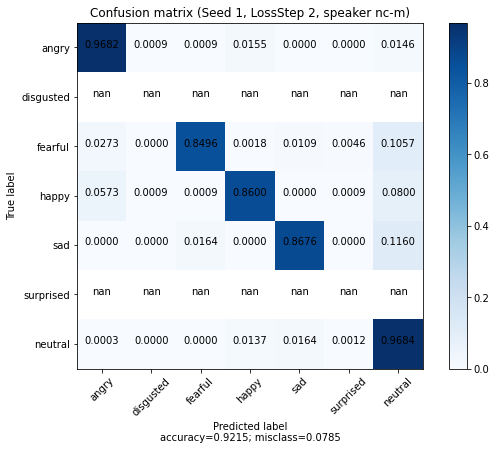

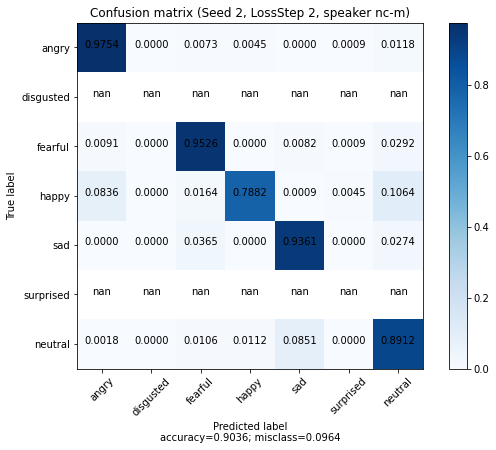

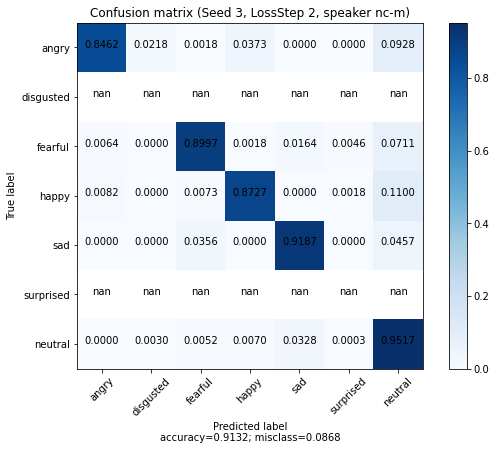

[Check consistent decision among 3 runnings]
Consistency of 3 runnings 0.7873
[For consistent emotion samples]
└ angry	 	 0.1358
└ disgusted	 	 0.0947
└ fearful	 	 0.1459
└ happy	 	 0.1551
└ neutral	 	 0.2108
└ sad	 	 0.1414
└ surprised	 	 0.1164
[For consistent emotion samples: speaker ketts-30f]
Consistency of 3 runnings 0.8929
└ angry	 	 0.1407
└ disgusted	 	 0.1272
└ fearful	 	 0.1452
└ happy	 	 0.1779
└ neutral	 	 0.136
└ sad	 	 0.128
└ surprised	 	 0.1451
[For consistent emotion samples: speaker ketts-30m]
Consistency of 3 runnings 0.8104
└ angry	 	 0.1364
└ disgusted	 	 0.1358
└ fearful	 	 0.1449
└ happy	 	 0.1589
└ neutral	 	 0.1292
└ sad	 	 0.1482
└ surprised	 	 0.1465
[For consistent emotion samples: speaker ketts2-20m]
Consistency of 3 runnings 0.6768
└ angry	 	 0.1757
└ disgusted	 	 0.0641
└ fearful	 	 0.0936
└ happy	 	 0.1586
└ neutral	 	 0.1744
└ sad	 	 0.1723
└ surprised	 	 0.1612
[For consistent emotion samples: speaker ketts2-30f]
Consistency of 3 runnings 0.8837
└ ang

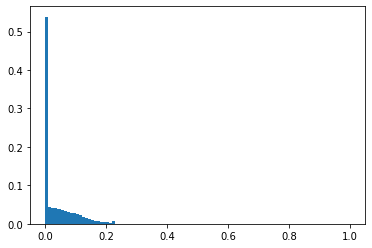


[Check MAE(3RunningEmotionVectors(consistent))]
Mean		 0.0147
Max		 0.1966
Min		 0.0
STD		 0.0259
Skewness	 1.9922


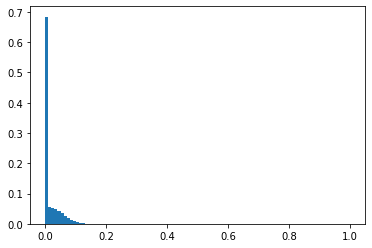


[Check MAE(3RunningEmotionVectors(inconsistent))]
Mean		 0.1184
Max		 0.3333
Min		 0.0069
STD		 0.0463
Skewness	 0.5744


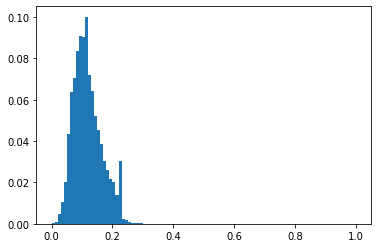


[Check MAE(3RunningEmotionVectorDim(consistent,predEmotions))]
Mean		 0.0409
Max		 0.3333
Min		 0.0
STD		 0.0779
Skewness	 2.0723


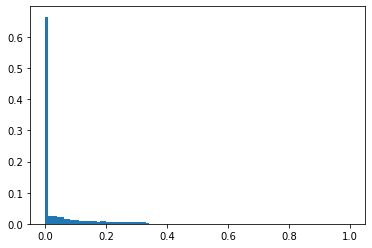


[Check MAE(3RunningEmotionVectorDim(consistent,TrueEmotions))]
Mean		 0.0417
Max		 0.5692
Min		 0.0
STD		 0.0793
Skewness	 2.0458


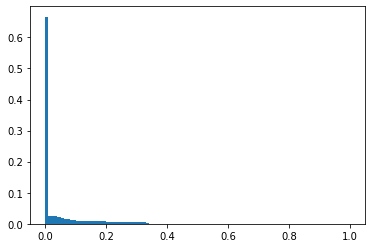


[Check MAE(3RunningEmotionVectorDim(inconsistent,TrueEmotions))]
Mean		 0.3366
Max		 0.6667
Min		 0.0
STD		 0.1838
Skewness	 0.0183


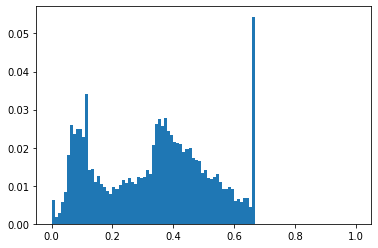


[Check MAE(3RunningEmotionVectorDim(total,TrueEmotions))]
Mean		 0.1044
Max		 0.6667
Min		 0.0
STD		 0.1634
Skewness	 1.689


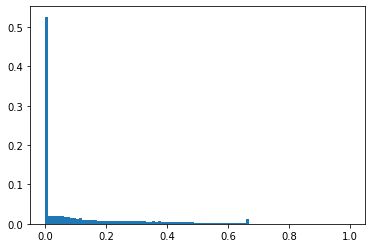

In [8]:
compute_stat(2)

## 2.3. Import 3 seeds of the 3rd loss

100%|██████████| 79168/79168 [00:12<00:00, 6121.47it/s]


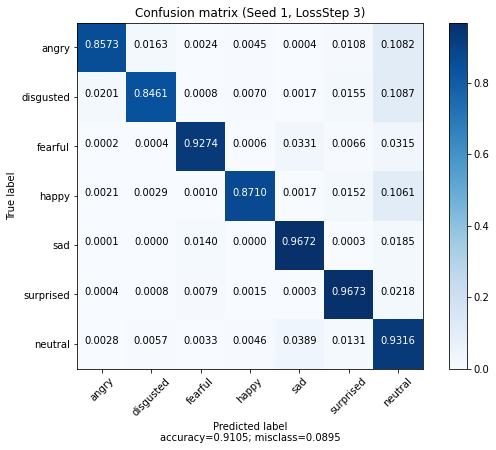

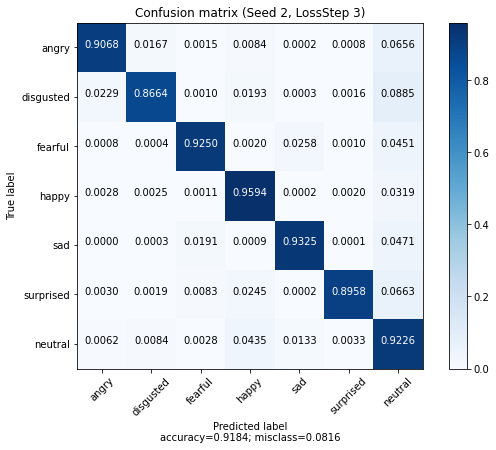

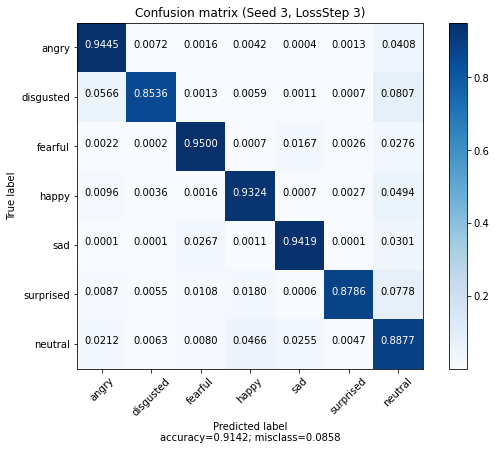

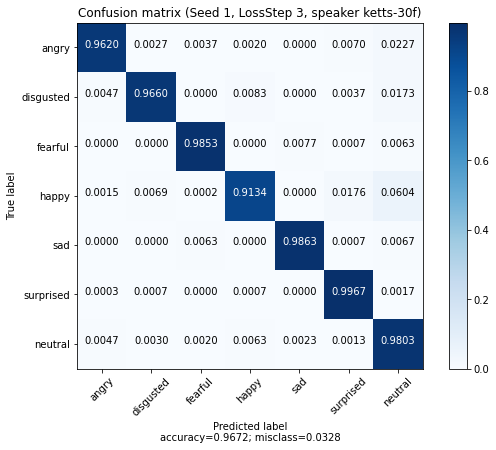

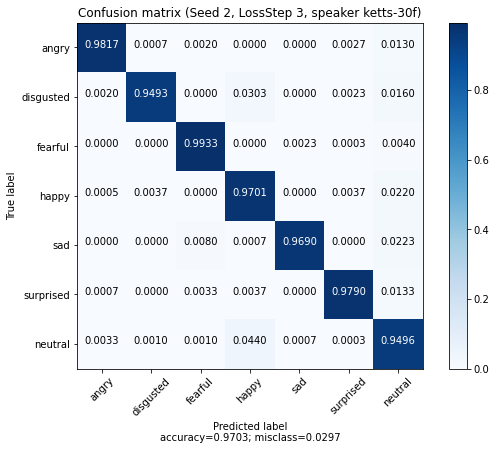

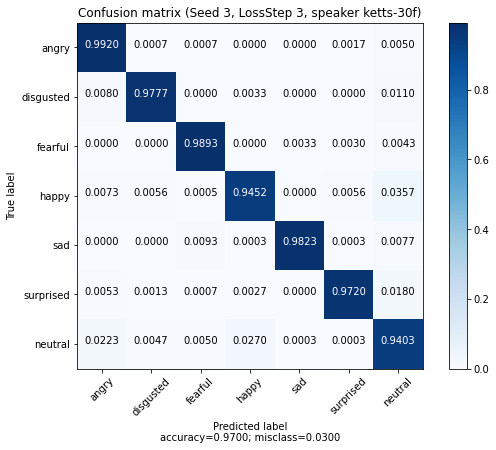

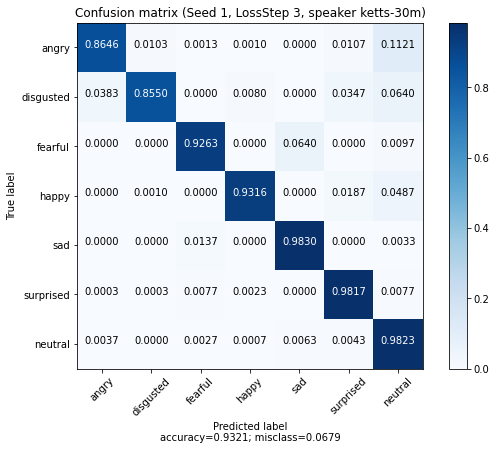

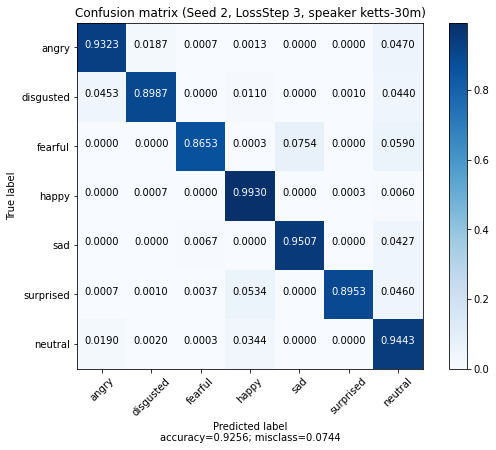

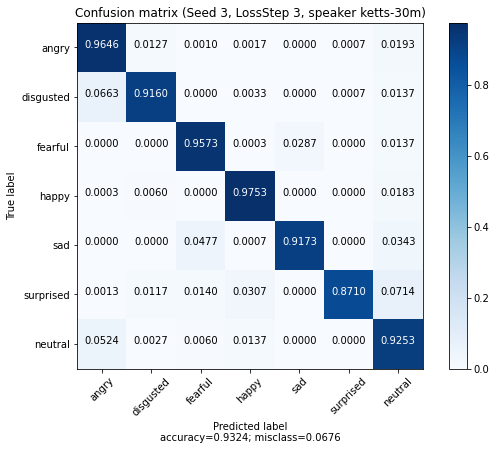

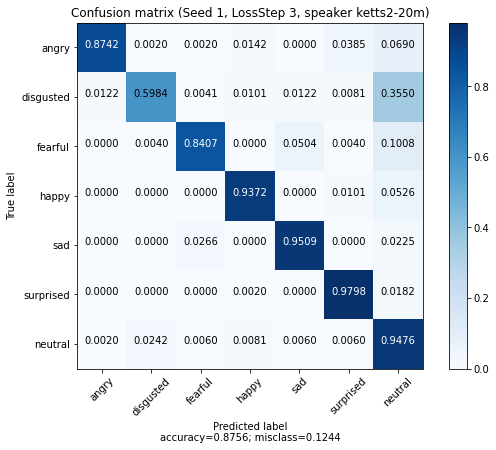

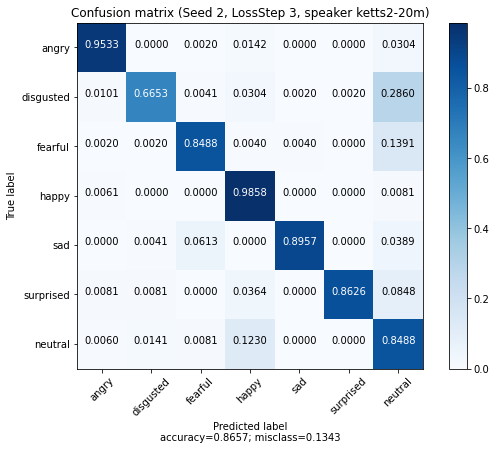

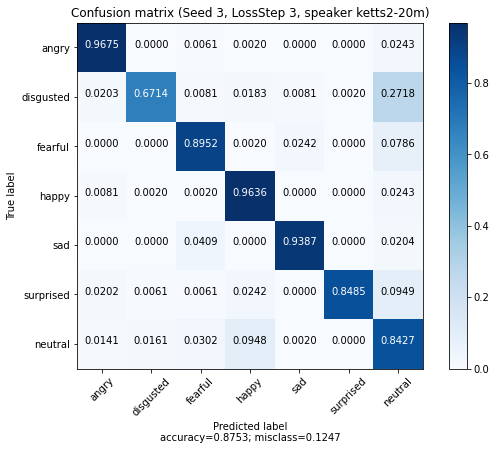

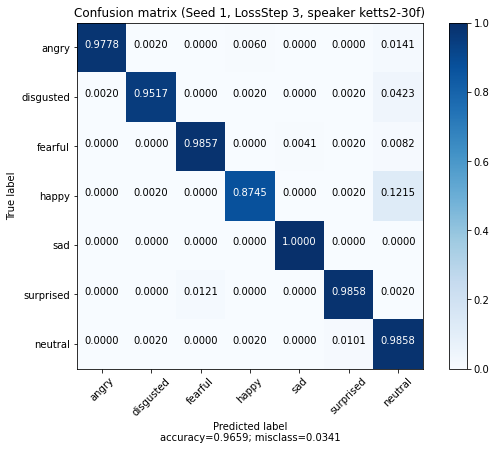

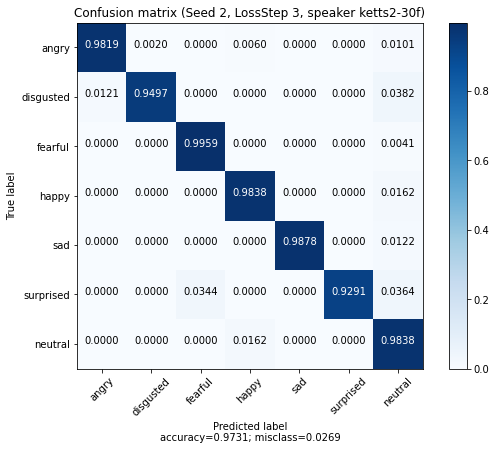

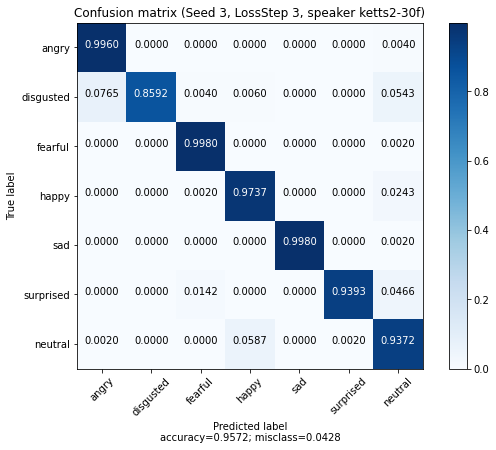

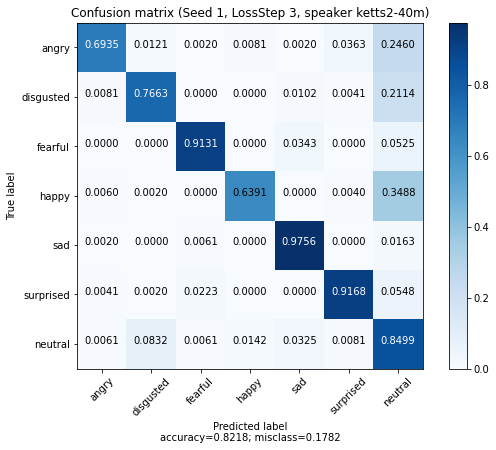

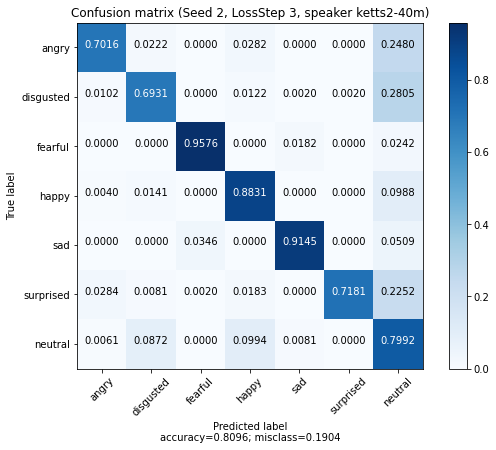

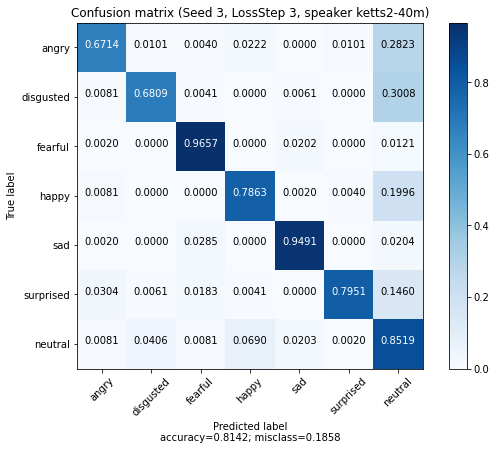

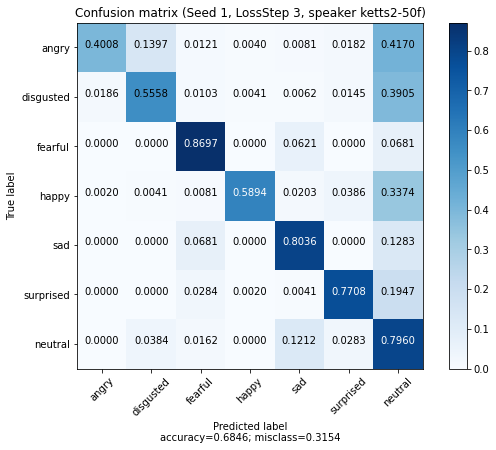

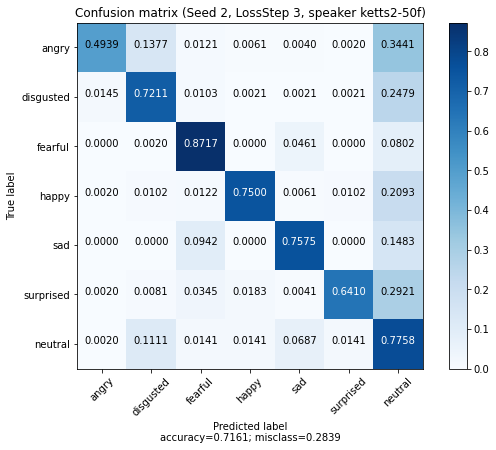

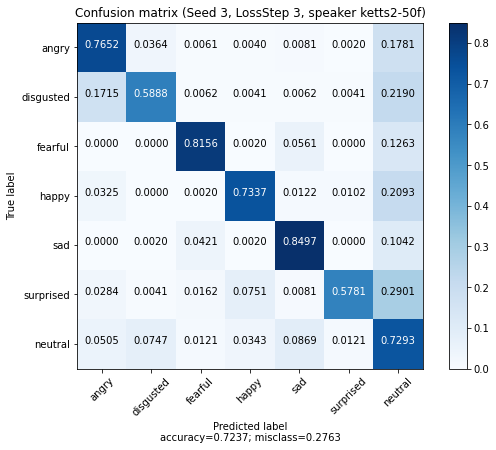

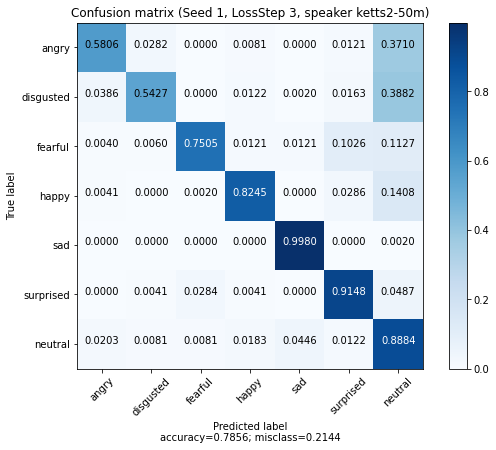

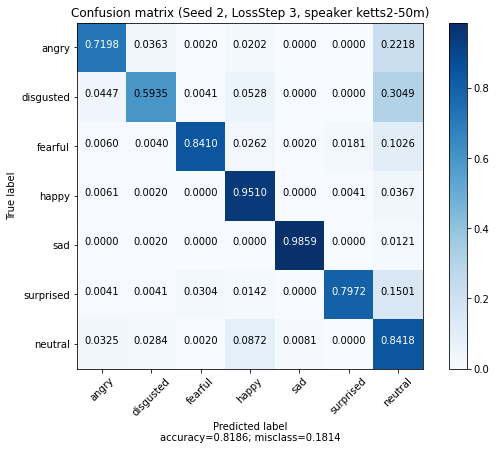

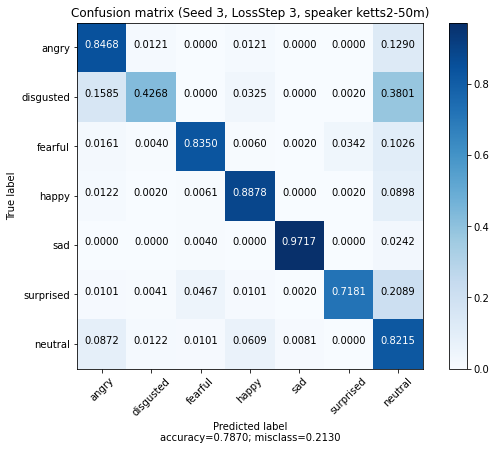

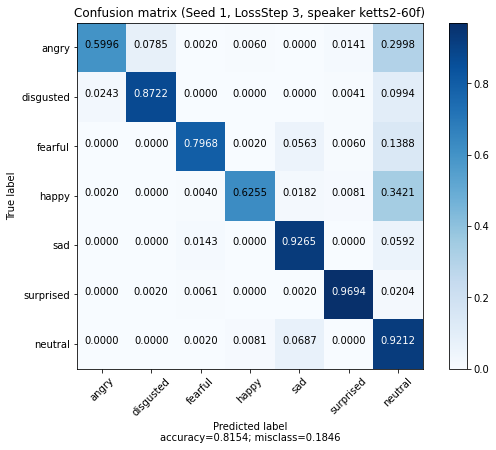

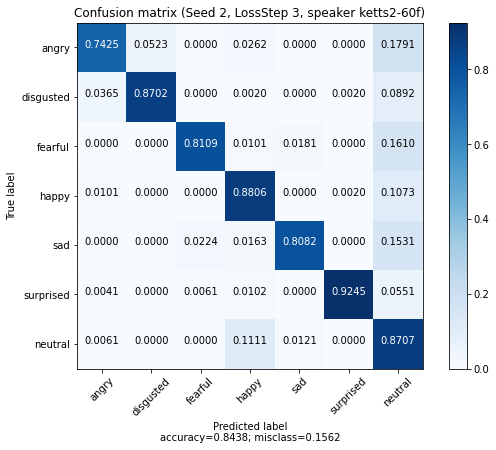

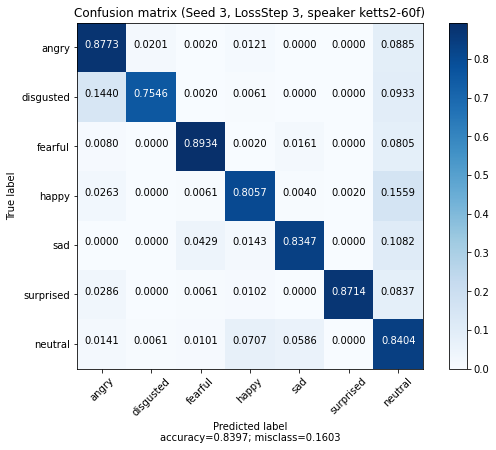

/data2/sungjaecho/anaconda3/envs/taco2/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


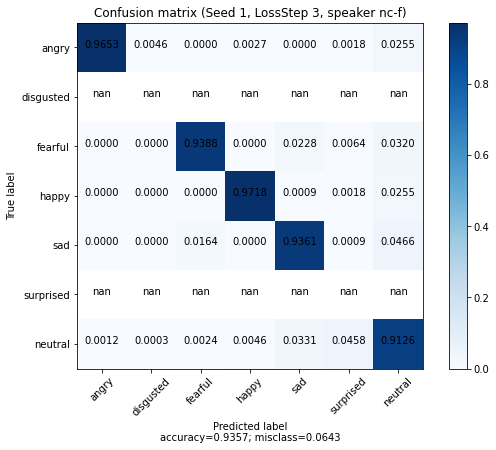

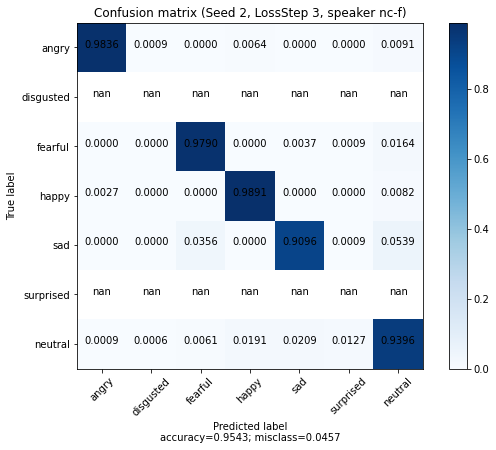

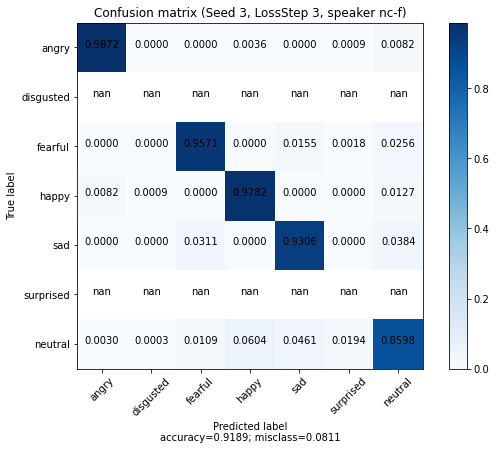

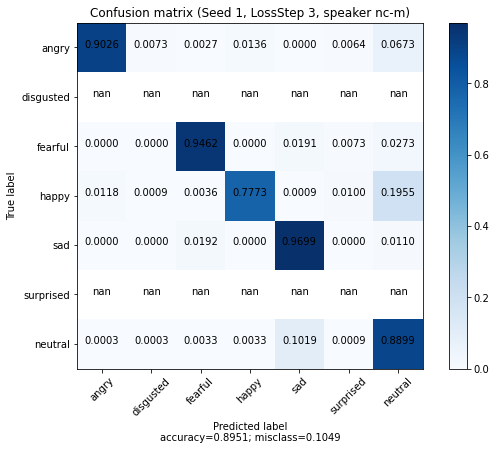

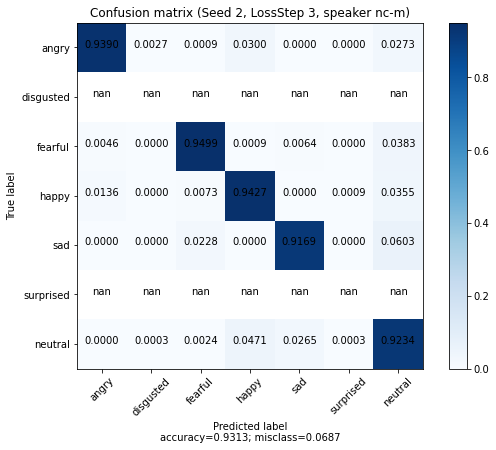

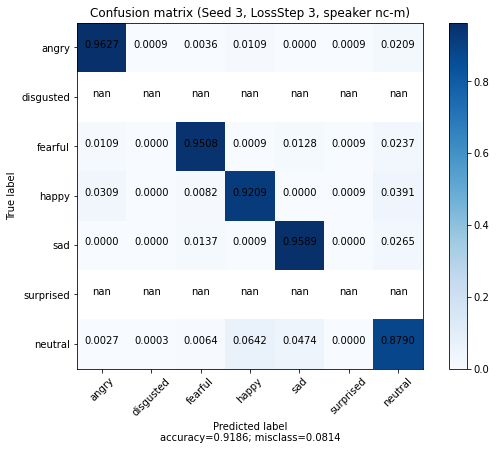

[Check consistent decision among 3 runnings]
Consistency of 3 runnings 0.8408
[For consistent emotion samples]
└ angry	 	 0.1376
└ disgusted	 	 0.1
└ fearful	 	 0.1469
└ happy	 	 0.1552
└ neutral	 	 0.1971
└ sad	 	 0.1517
└ surprised	 	 0.1116
[For consistent emotion samples: speaker ketts-30f]
Consistency of 3 runnings 0.9328
└ angry	 	 0.1384
└ disgusted	 	 0.1337
└ fearful	 	 0.1422
└ happy	 	 0.1757
└ neutral	 	 0.1311
└ sad	 	 0.1393
└ surprised	 	 0.1396
[For consistent emotion samples: speaker ketts-30m]
Consistency of 3 runnings 0.8556
└ angry	 	 0.1404
└ disgusted	 	 0.1322
└ fearful	 	 0.1395
└ happy	 	 0.1534
└ neutral	 	 0.148
└ sad	 	 0.1498
└ surprised	 	 0.1366
[For consistent emotion samples: speaker ketts2-20m]
Consistency of 3 runnings 0.7749
└ angry	 	 0.1553
└ disgusted	 	 0.078
└ fearful	 	 0.1355
└ happy	 	 0.1721
└ neutral	 	 0.1542
└ sad	 	 0.1606
└ surprised	 	 0.1441
[For consistent emotion samples: speaker ketts2-30f]
Consistency of 3 runnings 0.921
└ angry	 

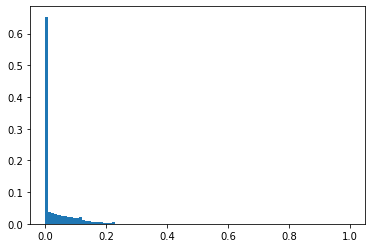


[Check MAE(3RunningEmotionVectors(consistent))]
Mean		 0.01
Max		 0.1973
Min		 0.0
STD		 0.0221
Skewness	 2.6551


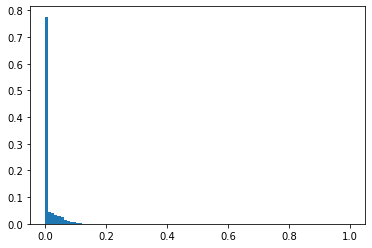


[Check MAE(3RunningEmotionVectors(inconsistent))]
Mean		 0.1224
Max		 0.3333
Min		 0.0102
STD		 0.0485
Skewness	 0.6815


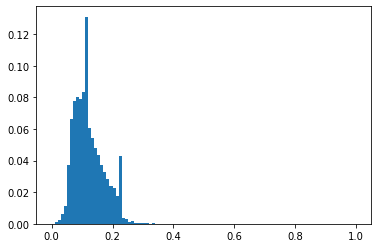


[Check MAE(3RunningEmotionVectorDim(consistent,predEmotions))]
Mean		 0.029
Max		 0.3333
Min		 0.0
STD		 0.0685
Skewness	 2.6534


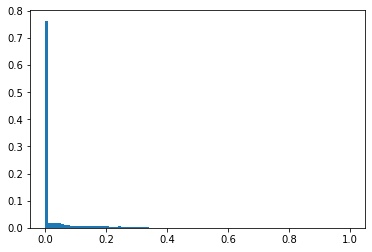


[Check MAE(3RunningEmotionVectorDim(consistent,TrueEmotions))]
Mean		 0.0293
Max		 0.5636
Min		 0.0
STD		 0.0693
Skewness	 2.6408


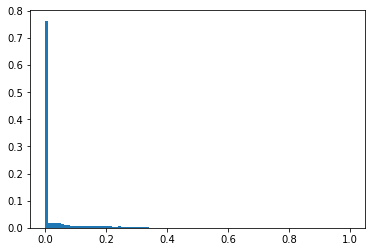


[Check MAE(3RunningEmotionVectorDim(inconsistent,TrueEmotions))]
Mean		 0.3542
Max		 0.6667
Min		 0.0
STD		 0.197
Skewness	 -0.0441


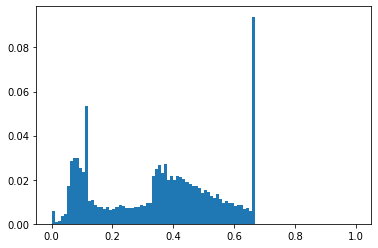


[Check MAE(3RunningEmotionVectorDim(total,TrueEmotions))]
Mean		 0.081
Max		 0.6667
Min		 0.0
STD		 0.156
Skewness	 2.1722


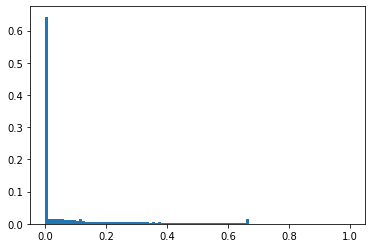

In [9]:
compute_stat(3)